# Tree Of Life Large Homework
This notebook contains everything you need to start off with building an improved phylogenetic tree of life

## Initialize libraries
Note that the nwalign3 library is a nice, quick Needleman-Wunsch implementation



In [ ]:
# Install the NW aligner package, an easy to use and reasonably performant package
from tqdm import tqdm
import gzip
import matplotlib
import random
%matplotlib inline
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd
import matplotlib.pyplot as plt
!pip install nwalign3 parasail biopython pysam
!apt-get install clustalw clustalo bwa samtools bcftools mafft
import pysam
from logging import exception
import time
import numpy as np
import nwalign3 as nw
import parasail as ps
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align.Applications import ClustalwCommandline
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO
from Bio.Align.Applications import ClustalOmegaCommandline
import os

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
bcftools is already the newest version (1.13-1).
bwa is already the newest version (0.7.17-6).
clustalo is already the newest version (1.2.4-7).
clustalw is already the newest version (2.1+lgpl-7).
mafft is already the newest version (7.490-1).
samtools is already the newest version (1.13-4).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


## Download gzipped fasta file of all known 18S sequences, load it into a dictionary

The files contains sequences as a header, which contains the sequence ID and exact taxonomic group, followed by the RNA sequence (note that in RNA, T nucleotides become U nucleotides)


```
    >GBHC01003613.162.1988 Eukaryota;Opisthokonta;Holozoa;Metazoa (Animalia);Eumetazoa;Bilateria;Chordata;Vertebrata;Gnathostomata;Euteleostomi;Actinopterygii;Neopterygii;Teleostei;Salmo salar (Atlantic salmon)
    CUUAAAUGAAGUUGCUGAGAAAAAGAAGCUUGUCUCAAAGAUUAAGCCAUGCAAGUCUAAGUACACACGGCCGGUACAGU
    GAAACUGCGAAUGGCUCAUUAAAUCAGUUAUGGUUCCUUUGAUCGCUCCAACGUUACUUGGAUAACUGUGGCAAUUCUAG
    #AGCUAAUACAUGCAGACGAGCGCUGACCUCCGGGGAUGCGUGCAUUUAUCAGACCCAAAACCCAUGCGGGCCAAUCUCGG
```

There are two major versions of the database, one is filtered down to discard sequences that are 99% identical within species:

https://www.arb-silva.de/fileadmin/silva_databases/release_138/Exports/SILVA_138_SSURef_NR99_tax_silva_trunc.fasta.gz

And the full, unfiltered version, that contains all sequences:

https://www.arb-silva.de/fileadmin/silva_databases/release_138/Exports/SILVA_138_SSURef_tax_silva_trunc.fasta.gz


In [ ]:
#Download gzipped fasta file of all known 18S sequences, load it into a dictionary
#!wget http://152.66.253.33:49080/ait/SILVA_128_SSURef_Nr99_tax_silva_trunc.fasta.gz
!wget https://www.arb-silva.de/fileadmin/silva_databases/release_138/Exports/SILVA_138_SSURef_NR99_tax_silva_trunc.fasta.gz
zipped_sequence_filename = "SILVA_138_SSURef_NR99_tax_silva_trunc.fasta.gz"

--2023-12-11 14:53:40--  https://www.arb-silva.de/fileadmin/silva_databases/release_138/Exports/SILVA_138_SSURef_NR99_tax_silva_trunc.fasta.gz
Resolving www.arb-silva.de (www.arb-silva.de)... 194.94.219.5
Connecting to www.arb-silva.de (www.arb-silva.de)|194.94.219.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196218395 (187M) [application/gzip]
Saving to: ‘SILVA_138_SSURef_NR99_tax_silva_trunc.fasta.gz’

SILVA_138_SSURef_NR 100%[===================>] 187.13M  30.5MB/s    in 6.7s    

2023-12-11 14:53:48 (28.1 MB/s) - ‘SILVA_138_SSURef_NR99_tax_silva_trunc.fasta.gz’ saved [196218395/196218395]



# Specify a list of keywords for taxonomic units to filter the sequences

Only sequences who's header contain any of the words in the keywords list will be loaded.

In [ ]:
keywords = []

# Load the sequences and filter them
The long-format species names and their corresponding 18S sequence data is loaded into a dictionary called `speciesNameToSequence`

In [ ]:
speciesNameToSequence = {} # keys are species names, values are 18S sequences
gap_open = 3
gap_extend = 1

def check_all_keywords_in_sequence_names(name):
    #Returns true if all keywords are present in the name of the sequence
    found = 0
    for keyword in keywords:
        if keyword.lower() in name.lower():
            found += 1
    if found == len(keywords):
        return True
    return False

def shorten_name(fullname):
    # Returns the sequence ID + last taxonomic unit (species) of a full name
    return fullname.partition(' ')[0]+' '+fullname.rpartition(';')[2]

def get_fasta_sequences_from_zip(filename):
    # Loads all sequences from a zip file, and checks their names against they keywords
    # Fasta format:
    #>GBHC01003613.162.1988 Eukaryota;Opisthokonta;Holozoa;Metazoa (Animalia);Eumetazoa;Bilateria;
    #Chordata;Vertebrata;Gnathostomata;Euteleostomi;Actinopterygii;Neopterygii;Teleostei;Salmo salar (Atlantic salmon)
    #CUUAAAUGAAGUUGCUGAGAAAAAGAAGCUUGUCUCAAAGAUUAAGCCAUGCAAGUCUAAGUACACACGGCCGGUACAGU
    #GAAACUGCGAAUGGCUCAUUAAAUCAGUUAUGGUUCCUUUGAUCGCUCCAACGUUACUUGGAUAACUGUGGCAAUUCUAG
    #AGCUAAUACAUGCAGACGAGCGCUGACCUCCGGGGAUGCGUGCAUUUAUCAGACCCAAAACCCAUGCGGGCCAAUCUCGG
    #...
    seq = []
    name = ''
    sequences_matching_filters = {}
    with gzip.open(filename,mode = 'rt') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if check_all_keywords_in_sequence_names(name):
                    seq = ''.join(seq)
                    #print (f"Length: {len(seq)} Shortname: {shorten_name(name)}")
                    sequences_matching_filters[name] = seq
                seq = []
                name = line
            else:
                seq.append(line)
    return sequences_matching_filters

The next step is to filter down the individual sequences

1.   One sequence per species (optionally chose the one that is most similar to all other species)
2.   Choose based on size (e.g. create a histogram of lengths)
3.   Select a manageable subset of species (based on any criteria)




In [ ]:
def trunc_unique_species(MAX_SEQUENCES, minimum_sequence_length):

  #MAX_SEQUENCES = 60 # the number of sequences to run on!
  unique = {}
  unique_species = [] # A list of species names that are unique, like Homo Sapeins
  unique_sequences = [] # a list of species that we will be using
  shortnames = []
  #minimum_sequence_length = 1600 #minimum length of 1600, because we are doing global and not local alignment...

  for name in speciesNameToSequence.keys():
      if ';' in name:
          speciesname = name.rpartition(';')[2] # remove the ID tags
          if len(speciesNameToSequence[name]) > minimum_sequence_length: #minimum length of 1600, because we are doing global and not local alignment...
              if speciesname not in unique_species:
                  unique_sequences.append(name)
                  unique_species.append(speciesname)

  unique_sequences = sorted(unique_sequences)

  unique_sequences = unique_sequences[0:MAX_SEQUENCES] #truncate the list to something more manageable

  print (f'Number of unique species: {len(unique_species)}')
  print (f'Number of sequences: {len(unique_sequences)}')

  for name in unique_sequences:
    unique[name] = speciesNameToSequence[name]

  shortnames = [n.rpartition(';')[2] for n in unique_sequences]
  print (', '.join(shortnames))

  return unique

## Create a distance matrix of the sequences ✅

We can use the NW aligners global alignment function to get the optimal alignment of two sequences.

`alignment = nw.global_align(s1, s2, match=1, gap_open=-1, gap_extend=-1, matrix=None)`



There are some gross simplifications here, with many areas for improvement

1.   Use local alignment instead of global alignment.
        This requires the usage of the parasail library rather than nwalign. Parasail is much faster as well! ✅(using semi-global alignment)
2.   Very simple scoring function ✅(pam250 or a handmade one)
3. Note that NW maximizes the alignment (similarity) score of two sequences, but we want to minimize the edit distance ✅(recalculated)


In [ ]:
#Using parasail

## Calculate Distance Matrix ✅

In [ ]:
def calculate_dist_matrix(sequences):
  l = len(sequences.items())

  distance_matrix = np.zeros((l,l))

  alignment_score_matrix = '\n'.join([
    '    A  C  G  U  *',
    'A   2 -1 -1 -1 -2',
    'C  -1  2 -1 -1 -2',
    'G  -1 -1  2 -1 -2',
    'U  -1 -1 -1  2 -1',
    '*  -2 -2 -2 -2 -2',
  ])

  max_score_per_base = 2

  with open("matrix.txt", 'w') as f: f.write(alignment_score_matrix)

  scoringm = ps.Matrix("matrix.txt")

  t0 = time.perf_counter()

  with tqdm(total= (l-1) * l/2 ) as pbar:
      for x, (name1, seq1) in enumerate(sequences.items()):
          for y, (name2, seq2) in enumerate(sequences.items()):
              if x == y:
                  distance_matrix[x,y] = 0
              if y > x:
                  pbar.update(1)
                  result = ps.sg_stats_striped_32(seq1, seq2, gap_open, gap_extend, scoringm) #ps.pam250)
                  distance_matrix[x,y]= max_score_per_base*min(len(seq1),len(seq2)) - result.score #(10000 - result.score) / 11

              else:
                  distance_matrix[x,y] = distance_matrix[y,x]

  print (f'Alignments in {time.perf_counter()-t0} seconds')

  shortnames = [n.rpartition(';')[2] for n in sequences.keys()]

  return distance_matrix, shortnames

## Draw the distance matrix ✅

In [ ]:
def draw_dist_matrix(matrix, shortnames):
  fig = plt.figure(figsize=(16,16))
  plt.imshow(matrix, cmap = 'jet')
  plt.colorbar()
  plt.yticks(np.arange(matrix.shape[0]), shortnames)
  plt.show();

## Cluster the distance matrix and create a dendrogram from it ✅

In [ ]:
def create_dendogram(distance_matrix, shortnames, method_left, method_top):
  # convert the redundant n*n square matrix form into a condensed nC2 array
  distArray = ssd.squareform(distance_matrix) # distArray[{n choose 2}-{n-i choose 2} + (j-i-1)] is the distance between points i and j
  print ("Distance matrix shape", distance_matrix.shape)

  #Initialize a large figure
  plt.rcParams['figure.figsize'] = [16, 16]
  fig = plt.figure(figsize=(32,32))
  textsize = 12

  # Create an axes object for the LEFT dendrogram
  ax1 = fig.add_axes([0.09,0.1,0.9,0.6])
  ax1.set_frame_on(False)
  ax1Blank = fig.add_axes([0.01,0.1,0.15,0.6])
  ax1Blank.set_frame_on(False)
  #clear axis ticks
  ax1.set_xticks([])
  ax1.set_yticks([])

  # Compute and plot LEFT dendrogram, using average weighted clusters, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
  Y = sch.linkage(distArray, method=method_left)
  Z1 = sch.dendrogram(Y, orientation='left', labels = shortnames, leaf_font_size = textsize)

  # Create an axes object for the TOP dendrogram
  ax2 = fig.add_axes([0.3,0.71,0.6,0.2])
  ax2Blank = fig.add_axes([0.3,0.85,0.6,0.2])
  ax2Blank.set_frame_on(False)
  ax2.set_frame_on(False)
  ax2.set_xticks([])
  ax2.set_yticks([])

  # Compute and plot TOP dendrogram, using minimum cluster distances
  Y = sch.linkage(distArray, method=method_top)
  Z2 = sch.dendrogram(Y, labels = shortnames, leaf_font_size = textsize)

  # Create an axes object for the distance matrix.
  axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])

  # Reorder the distance matrix according to the order of the leaves in the dendrogram
  idx1 = Z1['leaves']
  idx2 = Z2['leaves']

  distance_matrix_reordered = distance_matrix[idx1,:]
  distance_matrix_reordered = distance_matrix_reordered[:,idx2]
  im = axmatrix.matshow(distance_matrix_reordered, aspect='auto', origin='lower', cmap=plt.cm.YlGnBu)

  # Plot colorbar
  axcolor = fig.add_axes([0.91,0.1,0.01,0.6])
  plt.colorbar(im, cax=axcolor)
  fig.show()

# Large Homework Tasks

This large homework totals 50% of your grade for my part of the course for this semester, the rest being the small homeworks (30%) and class participation (20%).

There are many possible ways to improve your tree, and if you would like to achieve top marks, you will need to collect 100 points from the individual tasks outlined below. You do not need to complete all tasks.

**When working on individual tasks, please place your work in cells directly below each task you worked on. Naturally you may use multiple cells to structure your work. Explain your findings in markdown cells.**

## Conserved regions in mammals (30 points) ✅

*   Select all, or a subset of mammalian 18S sequences ✅
*   Find the one that is the most similar to all the others ✅
*   Align all sequences to that sequence ✅ (using MAFFT)
*   Walk along all alignments, and count the fraction of substition/indels ✅
*   Identify the most conserved regions, by plotting substitution and indel frequencies at each position ✅
*   Which regions are more likely to be loops or stems in the 18S ribosomal subunit? ✅ (thresholds can be fine tuned to see the probabilities better)


In [ ]:
def find_most_similar_sequence(sequences):
    best_sequence = None
    best_score = float('-inf')

    l = len(sequences.items())

    matrix = np.zeros((l,l))

    t0 = time.perf_counter()

    with tqdm(total= (l-1) * l/2 ) as pbar:
        for x, (name1, seq1) in enumerate(sequences.items()):
            for y, (name2, seq2) in enumerate(sequences.items()):
                if x == y:
                    matrix[x,y] = 0
                if y > x:
                    pbar.update(1)
                    result = ps.sg_stats_striped_32(seq1, seq2, gap_open, gap_extend, ps.pam250)
                    matrix[x,y]= result.score
                else:
                    matrix[x,y] = matrix[y,x]

    print (f'Alignments in {time.perf_counter()-t0} seconds')

    for x, (name1, seq1) in enumerate(sequences.items()):
      total_score = 0

      for y, (name2, seq2) in enumerate(sequences.items()):
        total_score += matrix[x,y]

      if total_score > best_score:
            best_score = total_score
            best_sequence = name1

    return best_sequence, best_score

In [ ]:
def write_temp_fasta(sequences):
    records = [SeqRecord(Seq(seq), id=name) for name, seq in sequences.items()]

    input_file = "temp_sequences.fasta"
    with open(input_file, "w") as temp_file:
        SeqIO.write(records, temp_file, "fasta")
    return input_file

def perform_msa_clustalomega(sequences):

    input_file = write_temp_fasta(sequences)

    clustalomega_cline = ClustalOmegaCommandline(infile=input_file, outfile="msa_result.fasta", verbose=True, auto=True)
    clustalomega_cline()

    aligned_seqs = list(SeqIO.parse("msa_result.fasta", "fasta"))

    os.remove("temp_sequences.fasta")
    os.remove("msa_result.fasta")

    return aligned_seqs

def perform_msa_clustalw(sequences):

    input_file = write_temp_fasta(sequences)

    clustalw_exe = r"clustalw"

    clustalw_cline = ClustalwCommandline(clustalw_exe, infile=input_file)
    stdout, stderr = clustalw_cline()

    aligned_seqs = AlignIO.read("temp_sequences.aln", "clustal")

    os.remove("temp_sequences.fasta")
    os.remove("temp_sequences.aln")

    return aligned_seqs

def perform_msa_bwa(sequences, reference):
  records = []

  for name, seq in sequences.items():
    if name != reference:
      records.append(SeqRecord(Seq(seq), id=name))

  reference_record = SeqRecord(Seq(sequences[reference]), id=reference)

  reference_file = "reference.fasta"
  with open(reference_file, "w") as temp_ref_file:
    SeqIO.write(reference_record, temp_ref_file, "fasta")

  input_file = "temp_sequences.fasta"
  with open(input_file, "w") as temp_file:
    SeqIO.write(records, temp_file, "fasta")

  !bwa index reference.fasta
  !bwa mem reference.fasta temp_sequences.fasta > aligned.sam
  !samtools view -bS aligned.sam | samtools sort -o aligned.sorted.bam

  try:
    os.remove("variants.vcf")
  except:
    print("variants.vcf does not exist yet")

  !bcftools mpileup -f reference.fasta aligned.sorted.bam | bcftools call -mv -Oz -o variants.vcf

  !cat variants.vcf

  os.remove("reference.fasta")
  os.remove("temp_sequences.fasta")
  os.remove("aligned.sam")
  os.remove("aligned.sorted.bam")

def perform_msa_mafft(sequences, reference):
  records = []

  for name, seq in sequences.items():
    if name != reference:
      records.append(SeqRecord(Seq(seq), id=name))

  reference_record = SeqRecord(Seq(sequences[reference]), id=reference)

  reference_file = "reference.fasta"
  with open(reference_file, "w") as temp_ref_file:
    SeqIO.write(reference_record, temp_ref_file, "fasta")

  input_file = "temp_sequences.fasta"
  with open(input_file, "w") as temp_file:
    SeqIO.write(records, temp_file, "fasta")

  !mafft --add temp_sequences.fasta reference.fasta > aligned.fasta

  aligned_seqs = list(SeqIO.parse("aligned.fasta", "fasta"))

  os.remove("reference.fasta")
  os.remove("temp_sequences.fasta")
  os.remove("aligned.fasta")

  return aligned_seqs

In [ ]:
keywords = ['Mammalia']

speciesNameToSequence = get_fasta_sequences_from_zip(zipped_sequence_filename)
print (f"{len(speciesNameToSequence)} names match keywords")

filtered_seqs = trunc_unique_species(85, 0)


556 names match keywords
Number of unique species: 82
Number of sequences: 82
Canis lupus familiaris (dog), Monodelphis domestica (gray short-tailed opossum), Loxodonta africana (African savanna elephant), Cavia porcellus (domestic guinea pig), Erinaceus europaeus (western European hedgehog), Tupaia belangeri (northern tree shrew), Ictidomys tridecemlineatus (thirteen-lined ground squirrel), Otolemur garnettii (small-eared galago), Equus caballus (horse), Ochotona princeps (American pika), Microcebus murinus (gray mouse lemur), Tursiops truncatus (bottlenosed dolphin), Carlito syrichta (Philippine tarsier), Homo sapiens (human), Pan troglodytes (chimpanzee), Myotis lucifugus (little brown bat), Pongo abelii (Sumatran orangutan), Felis catus (domestic cat), Nomascus leucogenys (northern white-cheeked gibbon), Sarcophilus harrisii (Tasmanian devil), Bos indicus, Papio anubis (olive baboon), Ornithorhynchus anatinus (platypus), Pan paniscus (pygmy chimpanzee), Octodon degus (degu), Mus mu

In [ ]:
reference_sequence, score = find_most_similar_sequence(filtered_seqs)

print(f"The most similar sequence is: {filtered_seqs[reference_sequence]} with a score of {score}")

100%|██████████| 3321/3321.0 [00:26<00:00, 123.13it/s]

Alignments in 26.978435975001048 seconds
The most similar sequence is: CCUGGUUGAUCCUGCCAGUAGCAUAUGCUUGUCUCAAAGAUUAAGCCAUGCAUGUCUAAGUACGCACGGCCGGUACAGUGAAACUGCGAAUGGCUCAUUAAAUCAGUUAUGGUUCCUUUGGUCGCUCGCUCCUCUCCUACUUGGAUAACUGUGGUAAUUCUAGAGCUAAUACAUGCCGACGGGCGCUGACCCCCUUCGCGGGGGGGAUGCGUGCAUUUAUCAGAUCAAAACCAACCCGGUCAGCCUCCUCCCGGCCCCGGCCGGGGGGCGGGCGCCGGCGGCUUUGGUGACUCUAGAUAACCUCGGGCCGAUCGCACGCCCCCCGUGGCGGCGACGACCCAUUCGAACGUCUGCCCUAUCAACUUUCGAUGGUAGUCGCUGUGCCUACCAUGGUGACCACGGGUGACGGGGAAUCAGGGUUCGAUUCCGGAGAGGGAGCCUGAGAAACGGCUACCACAUCCAAGGAAGGCAGCAGGCGCGCAAAUUACCCACUCCCGACCCGGGGAGGUAGUGACGAAAAAUAACAAUACAGGACUCUUUCGAGGCCCUGUAAUUGGAAUGAGUCCACUUUAAAUCCUUCCGCGAGGAUCCAUUGGAGGGCAAGUCUGGUGCCAGCAGCCGCGGUAAUUCCAGCUCCAAUAGCGUAUAUUAAAGUUGCUGCAGUUAAAAAGCUCGUAGUUGGAUCUUGGGAGCGGGCGGGCGGUCCGCCGCGAGGCGAGCCACCGCCCGUCCCCGCCCCUUGCCUCUCGGCGCCCCCUCGAUGCUCUUAGCUGAGUGUCCCGCGGGGCCCGAAGCGUUUACUUUGAAAAAAUUAGAGUGUUCAAAGCAGGCCCGAGCCGCCUGGAUACCGCAGCUAGGAAUAAUGGAAUAGGACCGCGGUUCUAUUUUGUUGGUUUUCGGAACUGAGGCCAUGAUUAAGAGGGACGGCC

In [ ]:
msa_result = perform_msa_mafft(filtered_seqs, reference_sequence) #mafft can align to a reference and it's format is easy to handle. Tried vcf format aswell.
msa = MultipleSeqAlignment(msa_result)
print(f"MSA:\n{msa}")

nadd = 81
nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..

There are 39 ambiguous characters.
    1 / 82
done.

Constructing a UPGMA tree (efffree=0) ... 
   80 / 82
done.

Progressive alignment 1/2... 
STEP    23 / 81  f
Reallocating..done. *alloclen = 4847
STEP    70 / 81  f
Reallocating..done. *alloclen = 5890
STEP    81 / 81  f
done.

Making a distance matrix from msa.. 
    0 / 82
done.

Constructing a UPGMA tree (efffree=1) ... 
   80 / 82
done.

Progressive alignment 2/2... 
STEP    33 / 81  f
Reallocating..done. *alloclen = 4851
STEP    77 / 81  f
Reallocating..done. *alloclen = 5894
STEP    81 / 81  f
done.

disttbfast (nuc) Version 7.490
alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

In [ ]:
msa_alignment = []
aligned_sequences = {}

for record in msa_result:
    msa_alignment.append(str(record.seq))
    aligned_sequences[record.id] = str(record.seq)
    print(record.id + " " + str(record.seq))

>CP027095.5202018.5203876 --ccugguugau-ccug-ccaguagcaua----ugcuugucuc-aaagauuaagccaugcaugucuaaguacgcacggccgguacagug-aaacugcg-aauggcucau-uaaaucaguuaugguuccuuuggucgcucgcuccucuccuac-uuggauaacug-u-gguaauucuagagcuaauacaugccgacgggc-gcugacccccuu------------------cgcggggg------------------------------------ggaugcgugcauuuaucaga----------------------uc-aaaaccaa---cccgguc----------------agccucc--ucccggcccc---------ggccg-gggggcgggcgccggcggcuu--------uggu---------------gacucuagauaa---ccucgggccgaucgcacg------ccccccguggcggcgacgacccauucgaac--------gucug-cccuaucaacuuucgau----gguagucgcugugccua-ccauggugacc--acgggugacg-gggaaucaggguu-cgauucc-ggagagggag---ccugagaaac-ggcuacc---acau-ccaaggaaggc--agcag-------------gcgcgcaaau-ua---cccacucccgaccc----ggggaggu--agugacgaaaaauaa--caauacaggacuc----uuucgaggc----ccuguaauu-ggaaugaguccacuuuaaaucc-uu-ccgcgaggau-ccauugga----------gggcaagucuggugccagcagccg-cgguaauuccagc------------------------------uccaauagcguauauuaaaguu-gcugcaguuaaaaagcu-----------------------cguaguuggauc-u

>CP027095.5202018.5203876
Substitution fraction: 0.0482
Indel fraction: 41.1367


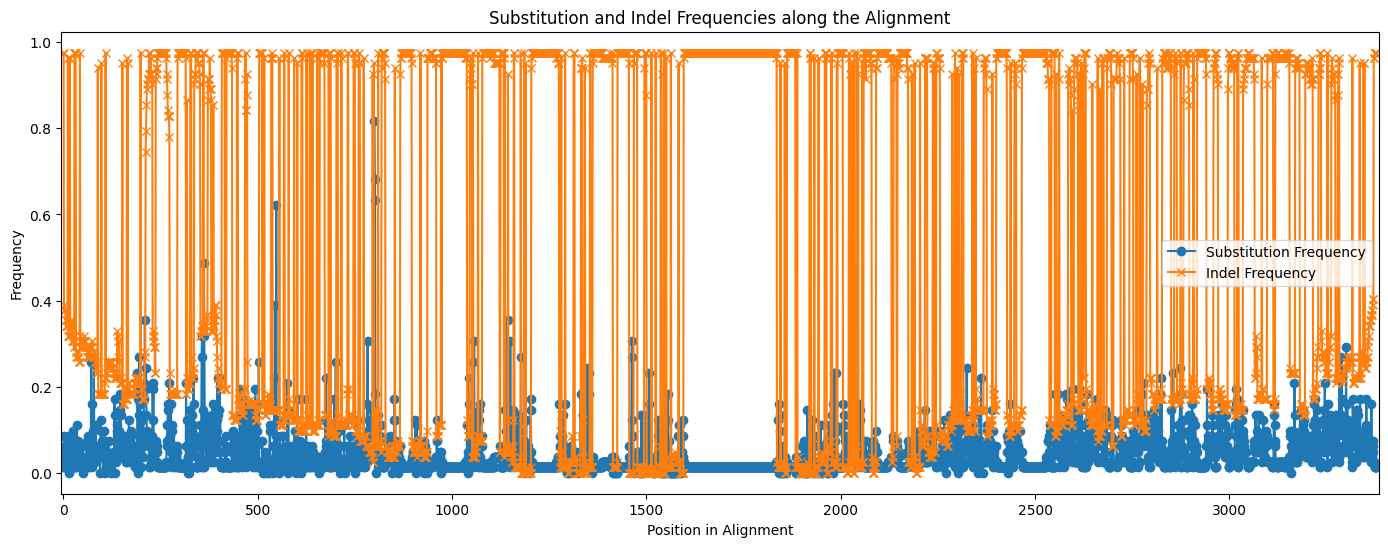

In [ ]:
substitution_count = 0
indel_count = 0

ref_sequence = reference_sequence.split(" ", 1)[0]

print(ref_sequence)

alignment_length = len(aligned_sequences[ref_sequence])

for i in range(alignment_length):
    reference_base = aligned_sequences[ref_sequence][i]

    for name, aligned_seq in aligned_sequences.items():
        if name != ref_sequence:
          if aligned_seq[i] == '-':
            indel_count += 1
          elif aligned_seq[i] != reference_base:
            substitution_count += 1

substitution_fraction = substitution_count / (alignment_length * (len(aligned_sequences) - 1))
indel_fraction = indel_count / alignment_length

substitution_count = 0
indel_count = 0

print(f"Substitution fraction: {substitution_fraction:.4f}")
print(f"Indel fraction: {indel_fraction:.4f}")

substitution_frequencies = []
indel_frequencies = []

for i in range(alignment_length):
    reference_base = aligned_sequences[ref_sequence][i]

    for name, aligned_seq in aligned_sequences.items():
        if name != ref_sequence:
          if aligned_seq[i] == '-':
            indel_count += 1
          elif aligned_seq[i] != reference_base:
            substitution_count += 1

    substitution_fraction = substitution_count / len(aligned_sequences)
    indel_fraction = indel_count / len(aligned_sequences)

    substitution_frequencies.append(substitution_fraction)
    indel_frequencies.append(indel_fraction)

    substitution_count = 0
    indel_count = 0

positions = list(range(0, alignment_length))
plt.figure(figsize=(17, 6))
plt.plot(positions, substitution_frequencies, label='Substitution Frequency', marker='o')
plt.plot(positions, indel_frequencies, label='Indel Frequency', marker='x')
plt.xlabel('Position in Alignment')
plt.ylabel('Frequency')
plt.xlim(-5, alignment_length + 5)
plt.legend()
plt.title('Substitution and Indel Frequencies along the Alignment')
plt.show()

Stem positions: [73, 80, 192, 197, 210, 211, 213, 233, 274, 317, 336, 357, 358, 363, 364, 398, 404, 504, 544, 546, 547, 549, 577, 677, 702, 784, 801, 802, 803, 1045, 1054, 1058, 1144, 1151, 1179, 1348, 1354, 1463, 1464, 1509, 1984, 1990, 2035, 2325, 2362, 2779, 2826, 2856, 2874, 3168, 3246, 3284, 3289, 3301]
Loop positions: [1, 2, 13, 18, 30, 31, 32, 33, 44, 99, 110, 153, 165, 167, 200, 222, 223, 226, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 328, 329, 330, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 361, 362, 378, 409, 410, 411, 412, 413, 414, 415, 416, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 448, 449, 450, 470, 505, 506, 507, 508, 509, 510, 511, 512, 518, 536, 537, 538, 539, 557, 569, 570, 581, 595, 603, 614, 615, 616, 627, 635, 636, 637, 642, 654, 655, 661, 662, 

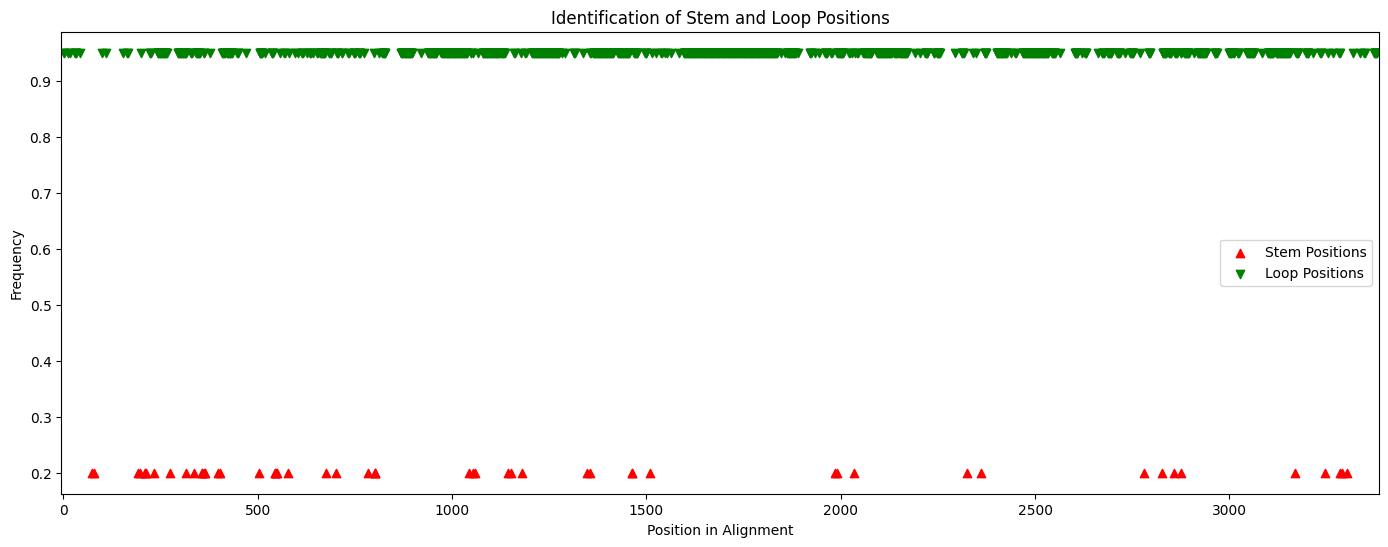

In [ ]:
stem_threshold = 0.2
loop_threshold = 0.95

stem_positions = [i + 1 for i, freq in enumerate(substitution_frequencies) if freq > stem_threshold]
loop_positions = [i + 1 for i, freq in enumerate(indel_frequencies) if freq > loop_threshold]

print(f"Stem positions: {stem_positions}")
print(f"Loop positions: {loop_positions}")

plt.figure(figsize=(17, 6))
plt.scatter(stem_positions, [stem_threshold] * len(stem_positions), color='red', label='Stem Positions', marker='^')
plt.scatter(loop_positions, [loop_threshold] * len(loop_positions), color='green', label='Loop Positions', marker='v')
plt.xlabel('Position in Alignment')
plt.ylabel('Frequency')
plt.legend()
plt.title('Identification of Stem and Loop Positions')
plt.xlim(-5, alignment_length + 5)
plt.show()

## Identify stems and loops (20 points) ✅

*   Brush off your implementations of the Smith-Waterman algorithm ✅ (using parasail as I already implemented this in an other assignment)
*   Align any 18S sequence to its own reverse complement ✅
*   Exhaustively search for alignments that indicate short stems



In [ ]:
id, sequence_to_align = random.choice(list(aligned_sequences.items()))

reverse_complement = sequence_to_align.translate(str.maketrans("ACGU", "UGCA"))[::-1]

result = ps.sw_trace_striped_32(sequence_to_align, reverse_complement, gap_open, gap_extend, ps.pam250)
aligned_seq = result.traceback.ref
aligned_reverse_complement = result.traceback.query
alignment_score = result.score

print(f"Original sequence: {sequence_to_align}")
print(f"Reverse sequence:  {reverse_complement}")
print(f"Aligned sequence:           {aligned_seq}")
print(f"Comparison:                 {result.traceback.comp}")
print(f"Aligned reverse complement: {aligned_reverse_complement}")
print(f"Alignment score: {alignment_score}")

def find_short_stems(sequence, min_stem_length=3):
    stems = []

    for i in range(len(sequence) - min_stem_length + 1):
        for j in range(i + min_stem_length, min(i + min_stem_length * 2, len(sequence) + 1)):
            subsequence1 = sequence[i:j]
            reverse_complement1 = subsequence1.translate(str.maketrans("ACGU", "UGCA"))[::-1]

            aligned_seq, aligned_reverse_complement, alignment_score = smith_waterman(subsequence1, reverse_complement1)

            if alignment_score >= min_stem_length:
                stems.append((i, j, alignment_score, aligned_seq, aligned_reverse_complement))

    return stems

Original sequence: GGACUGGAGAGGCCUCGGGAUCCCACCUCGGCCGGCGGGCGAGCCGCCGGCCCUCACCUUCAUUGCGCCACGGCGGCUUUCGUGCGAGCCCCCGACUCGCGCACGUGUUAGACUCCUUGGUCCGUGUUACAAGACGGGUCGGGUGGGUGGCCGACAUCGCCGCCGACCCCGUGCGCUCGCUUCGCGUGGCGCCUUGACCCCCCGGGCCCGACGGCGCGACCCGCCCGGGGCGCACUGGGGACAGUCCGCCCCGCCCCCGGCACCCCCCGCCCCCCCCCCCCCCCCCGCCCCUUGCCUCUCGGCGCCCCCUCGAUGCUCUUAGCUGAGUGUCCCGCGGGGCCCGAAGCGUUUACUUUGAAAAAAUUAGAGUGUUCAAAGCAGGCCCGAGCCGCCUGGAUACCGCAGCUAGGAAUAAUGGAAUAGGACCGCGGUUCUAUUUUGUUGGUUUUCGGAACUGAGGCCAUGAUUAAGAGGGACGGCCGGGGGCAUUCGUAUUGCGCCGCUAGAGGUGAAAUUCUUGGACCGGCGCAAGACGGACCAGAGCGAAAGCAUUUGCCAAGAAUGUUUUCAUUAAUCAAGAACGAAAGUCGGAGGUUCGAAGACGAUCAGAUACCGUCGUAGUUCCGACCAUAAACGAUGCCGACUGGCGAUGCGGCGGCGUUAUUCCCAUGACCCGCCGGGCAGCUUCCGGGAAACCAAAGUCUUUGGGUUCCGGGGGGAGUAUGGUUGCAAAGCUGAAACUUAAAGGAAUUGACGGAAGGGCACCACCAGGAGUGGAGCCUGCGGCUUAAUUUGACUCAACACGGGAAACCUCACCCGGCCCGGACACGGACAGGAUUGACAGAUUGAUAGCUCUUUCUCGAUUCCGUGGGUGGUGGUGCAUGGCCGUUCUUAGUUGGUGGAGCGAUUUGUCUGGUUAAUUCCGAUAACGAACGAGACUCUGGCAUGCUAACUAGUUACGCGACCCCCGAGCGGUCGGCG

In [ ]:
short_stems = find_short_stems(sequence_to_align, min_stem_length=3)

for i, j, score, aligned_seq, aligned_reverse_complement in short_stems:
    print(f"Stem positions: {i+1}-{j} (Score: {score})")
    print(f"Aligned sequence: {aligned_seq}")
    print(f"Aligned reverse complement: {aligned_reverse_complement}")
    print("\n")

## Compare mutation rates in conserved regions vs stems and loops (10 points)

*   Requires completion of the previous two tasks
*   Test the hypothesis that substitutions and indels are more frequent in loops than stems.

## Faster alignment (20 points) ✅

The parasail library is an order of magnitude faster at performing alignments, and it also has semi-global alignment options, where insertions and deletions from the starts and ends of pairs of sequences are not punished.

It is highly recommended that you try your hand at using Parasail instead of nwalign3.

Documentation available here: https://github.com/jeffdaily/parasail-python


Define a substitution matrix according to: https://github.com/jeffdaily/parasail-python#substitution-matrices

In [ ]:
#Parasail and different scoring matrices implemented in the above and below codes.

## Empirical Mutation Model (25 Points)

Some mutations are more likely than others.

Transitions (A/U, C/G) may be more likely than transversions (all others)

Indels also have different frequencies

Task:
*   Find a better scoring scheme than +1/-1
*   Idea: Starting from a simple scheme, can scores be derived from known mutation likelihoods, and iteratively refined until convergence?
*   Align all pairs of sequences for a branch of the tree
*   Calculate substitution and indel rates from the alignments
*   Assign new substitution and indels scores from the empirical rates
*   Repeat until convergence
*   Compare tree with new scores to initial tree


## Jukes/Cantor or Kimura Mutation Models (20 Points)

The number of mutations that happened since two species diverged is greater than the observed edit distance.

Task:
*   Estimate Ksup, the expected number of mutations that happened, from the observed edit distance
*   Is this function monotonic? Do monotonic transformations of distances between species lead to different trees?



## Different Clustering Methods (15 Points) ✅

*   We cannot know the common ancestral sequences in the branches of the evolutionary tree
*   Which linkage criterion gives a good estimation? ✅ Complete method
*   Try multiple different linkage criteria, and compare the resulting trees. ✅


In [ ]:
keywords = ['Vertebrata']

speciesNameToSequence = get_fasta_sequences_from_zip(zipped_sequence_filename)
print (f"{len(speciesNameToSequence)} names match keywords")

filtered_seqs = trunc_unique_species(65, 1600)

1106 names match keywords
Number of unique species: 257
Number of sequences: 65
Canis lupus familiaris (dog), Monodelphis domestica (gray short-tailed opossum), Loxodonta africana (African savanna elephant), Cavia porcellus (domestic guinea pig), Xenopus tropicalis (tropical clawed frog), Gasterosteus aculeatus (three-spined stickleback), Erinaceus europaeus (western European hedgehog), Tupaia belangeri (northern tree shrew), Ictidomys tridecemlineatus (thirteen-lined ground squirrel), Otolemur garnettii (small-eared galago), Equus caballus (horse), Anolis carolinensis (green anole), Megalobrama amblycephala, Microcebus murinus (gray mouse lemur), Tursiops truncatus (bottlenosed dolphin), Carlito syrichta (Philippine tarsier), Homo sapiens (human), Pan troglodytes (chimpanzee), Myotis lucifugus (little brown bat), Pongo abelii (Sumatran orangutan), Felis catus (domestic cat), Nomascus leucogenys (northern white-cheeked gibbon), Anas platyrhynchos (mallard), Petromyzon marinus (sea lamp

In [ ]:
matrix, shortnames = calculate_dist_matrix(filtered_seqs)

100%|██████████| 2080/2080.0 [00:25<00:00, 80.03it/s]

Alignments in 25.998801313999138 seconds


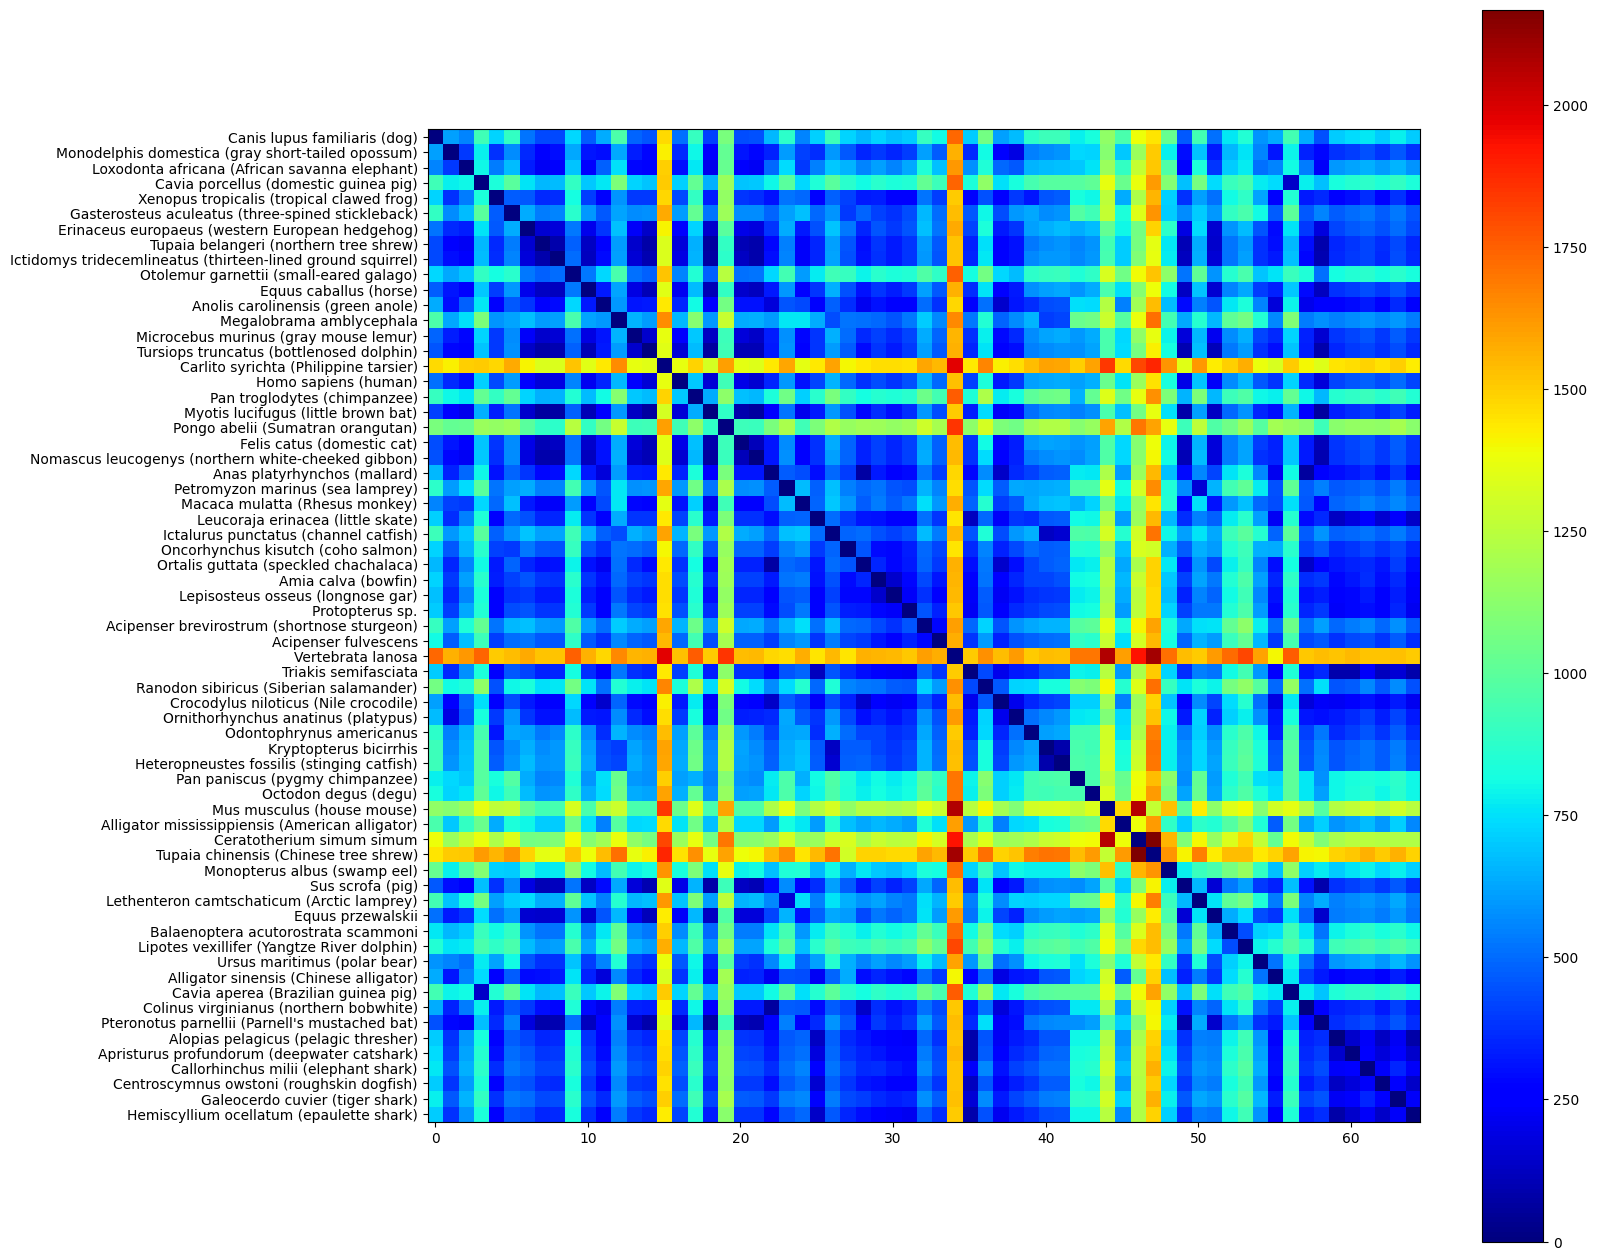

In [ ]:
draw_dist_matrix(matrix, shortnames)
longnames = [';'.join(n.split(';')[-3:]) for n in filtered_seqs.keys()]

Distance matrix shape (65, 65)


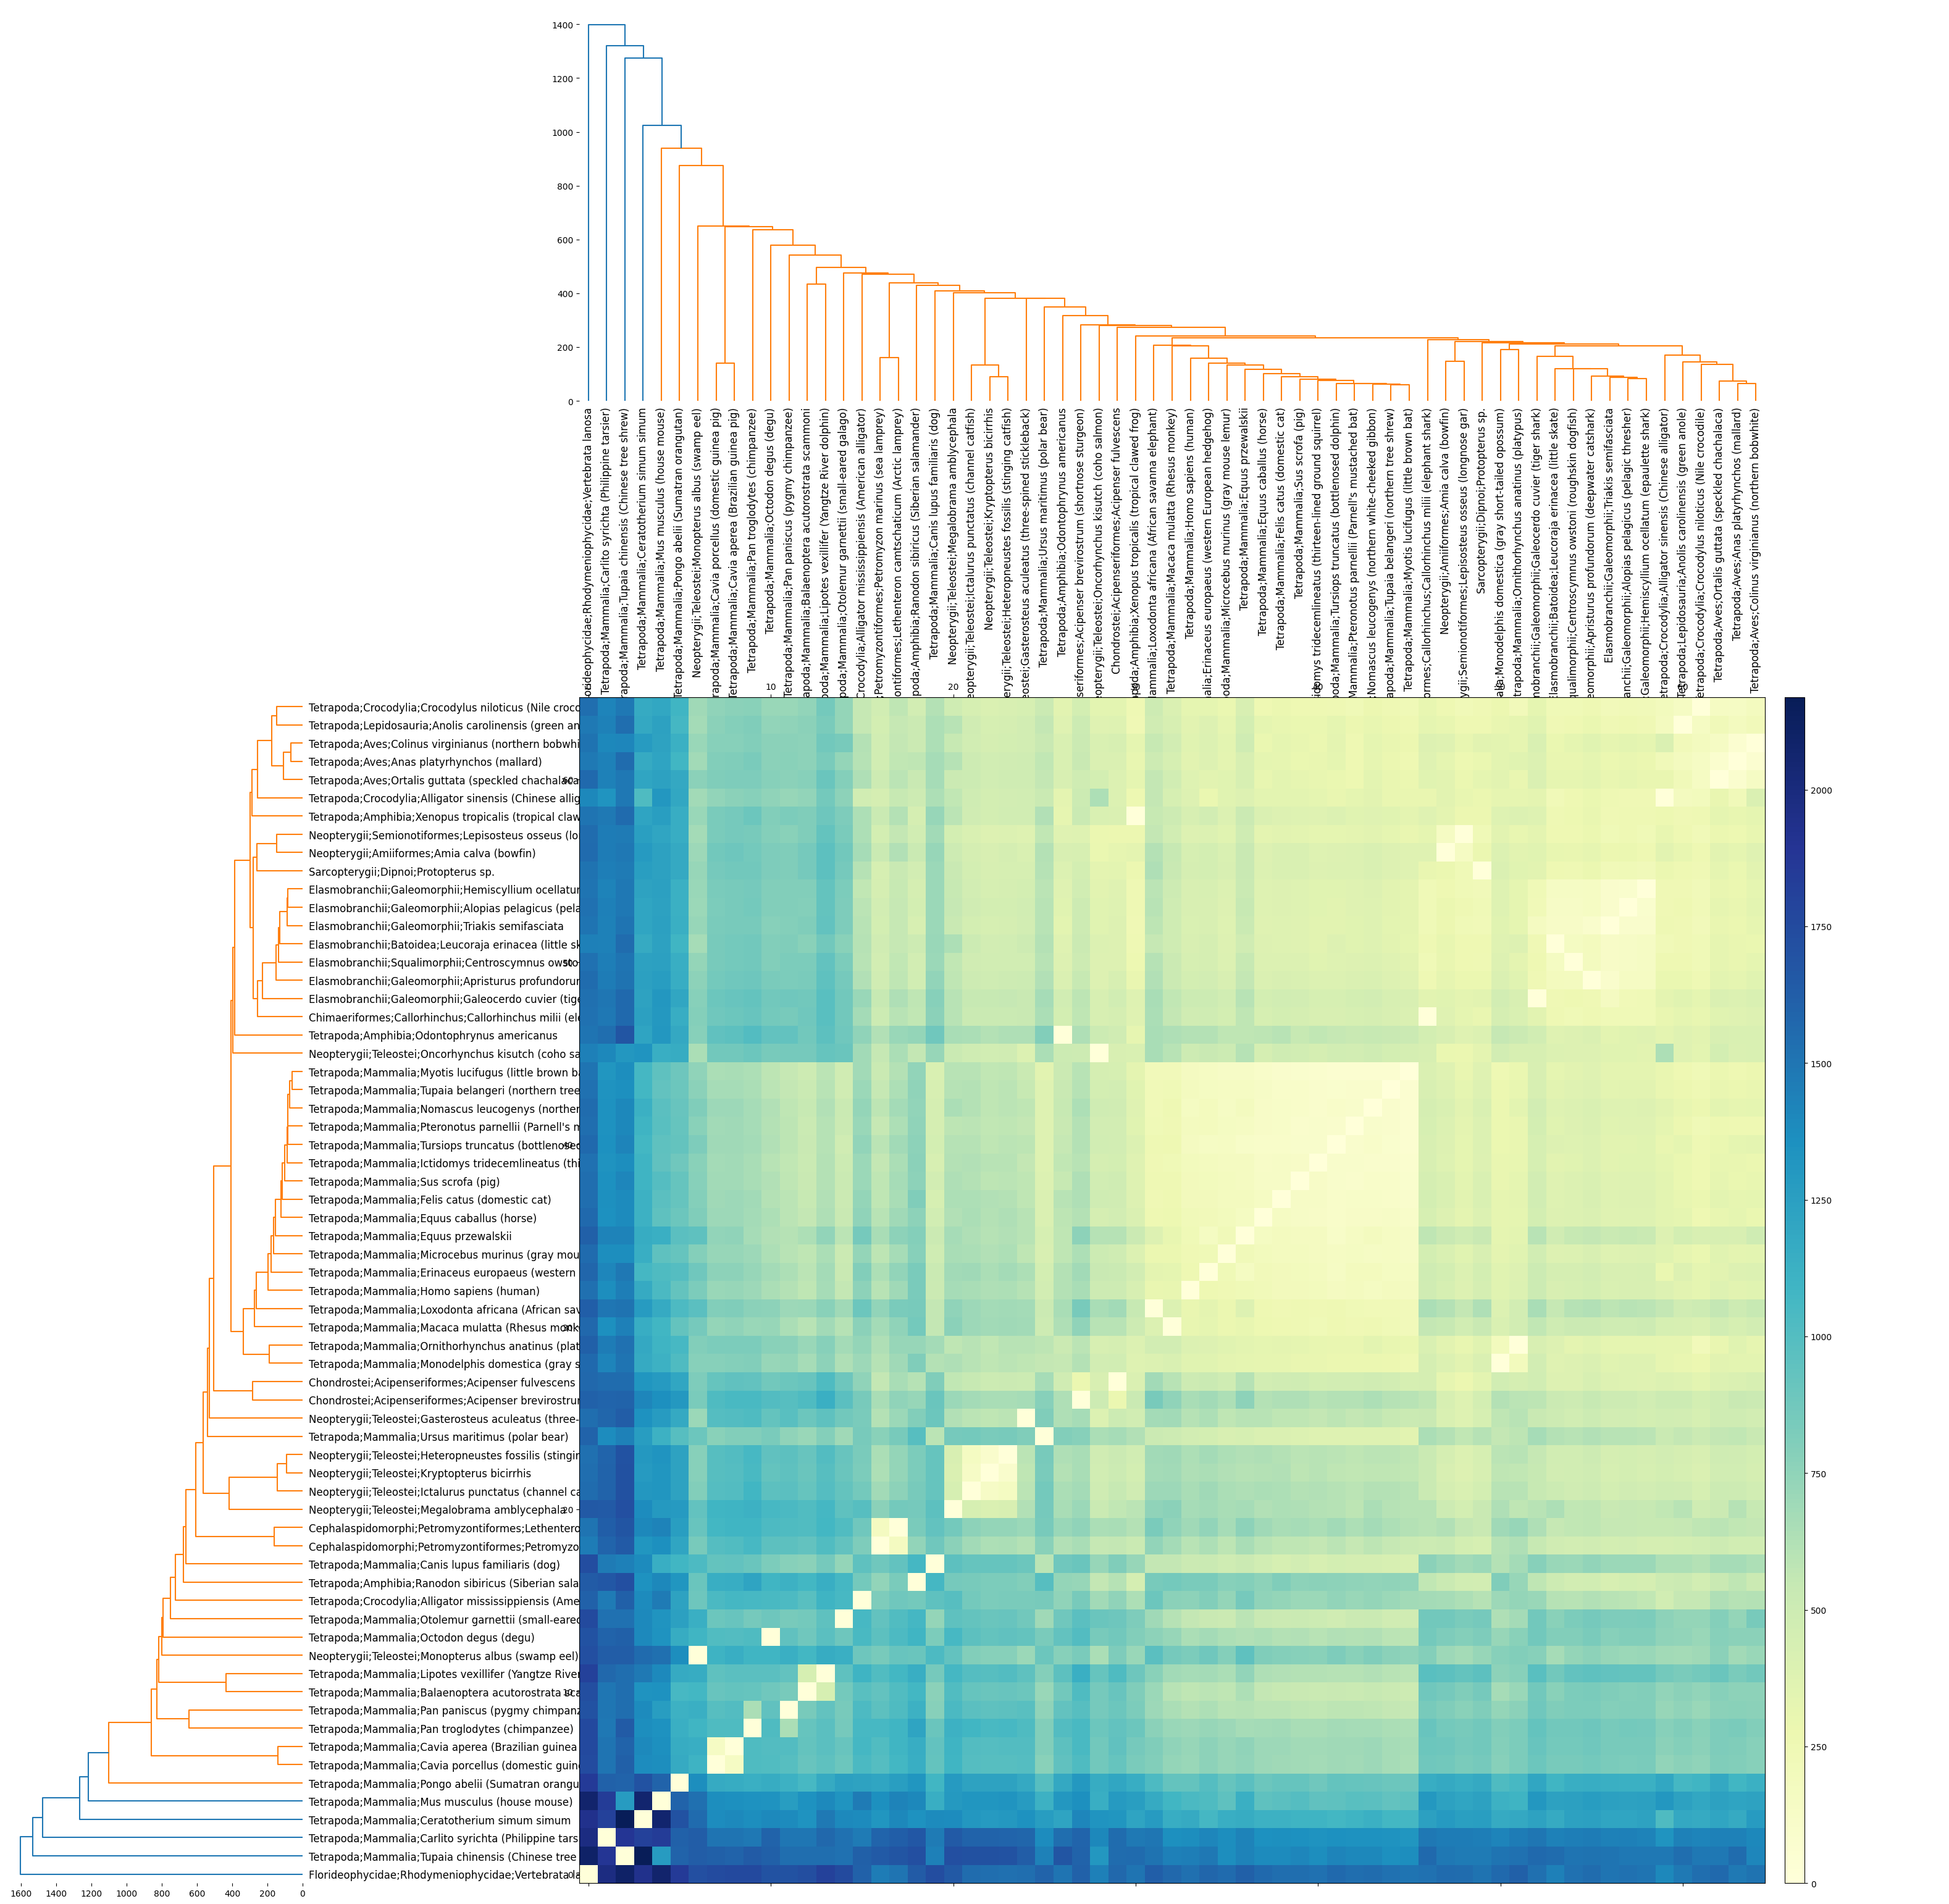

In [ ]:
create_dendogram(matrix, longnames, 'average', 'single')

Distance matrix shape (65, 65)


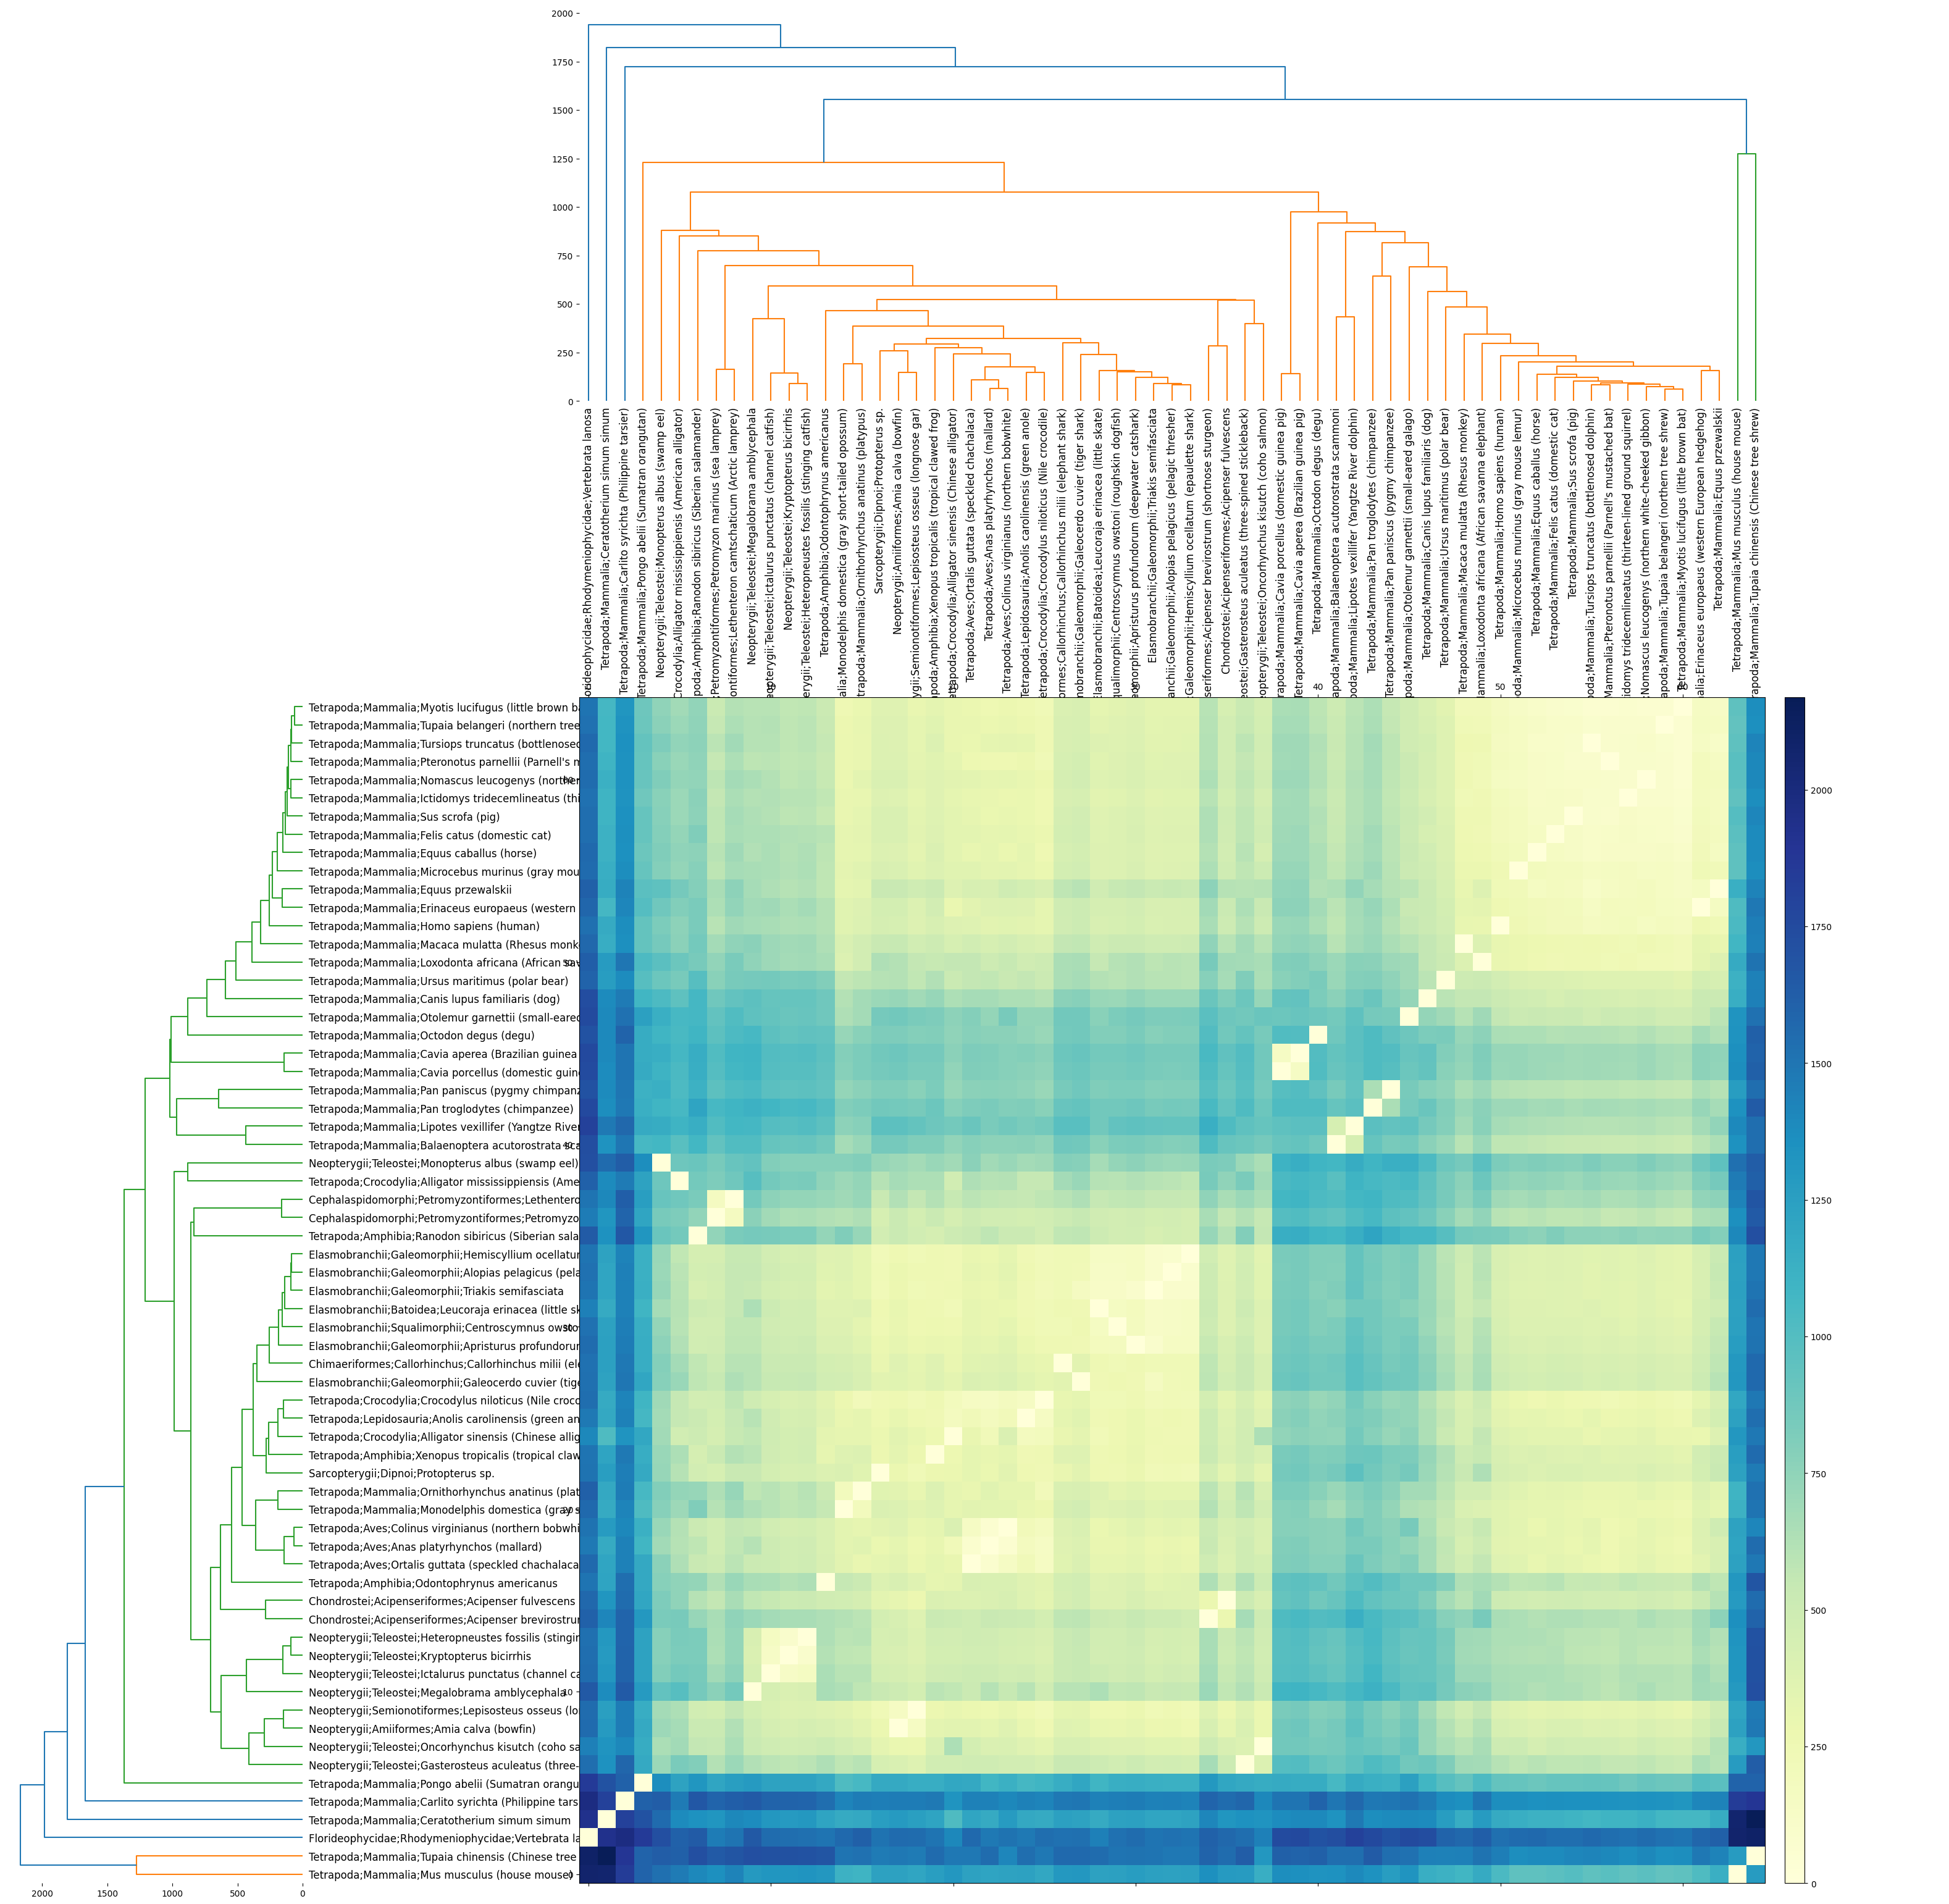

In [ ]:
create_dendogram(matrix, longnames, 'complete', 'weighted')

Distance matrix shape (65, 65)


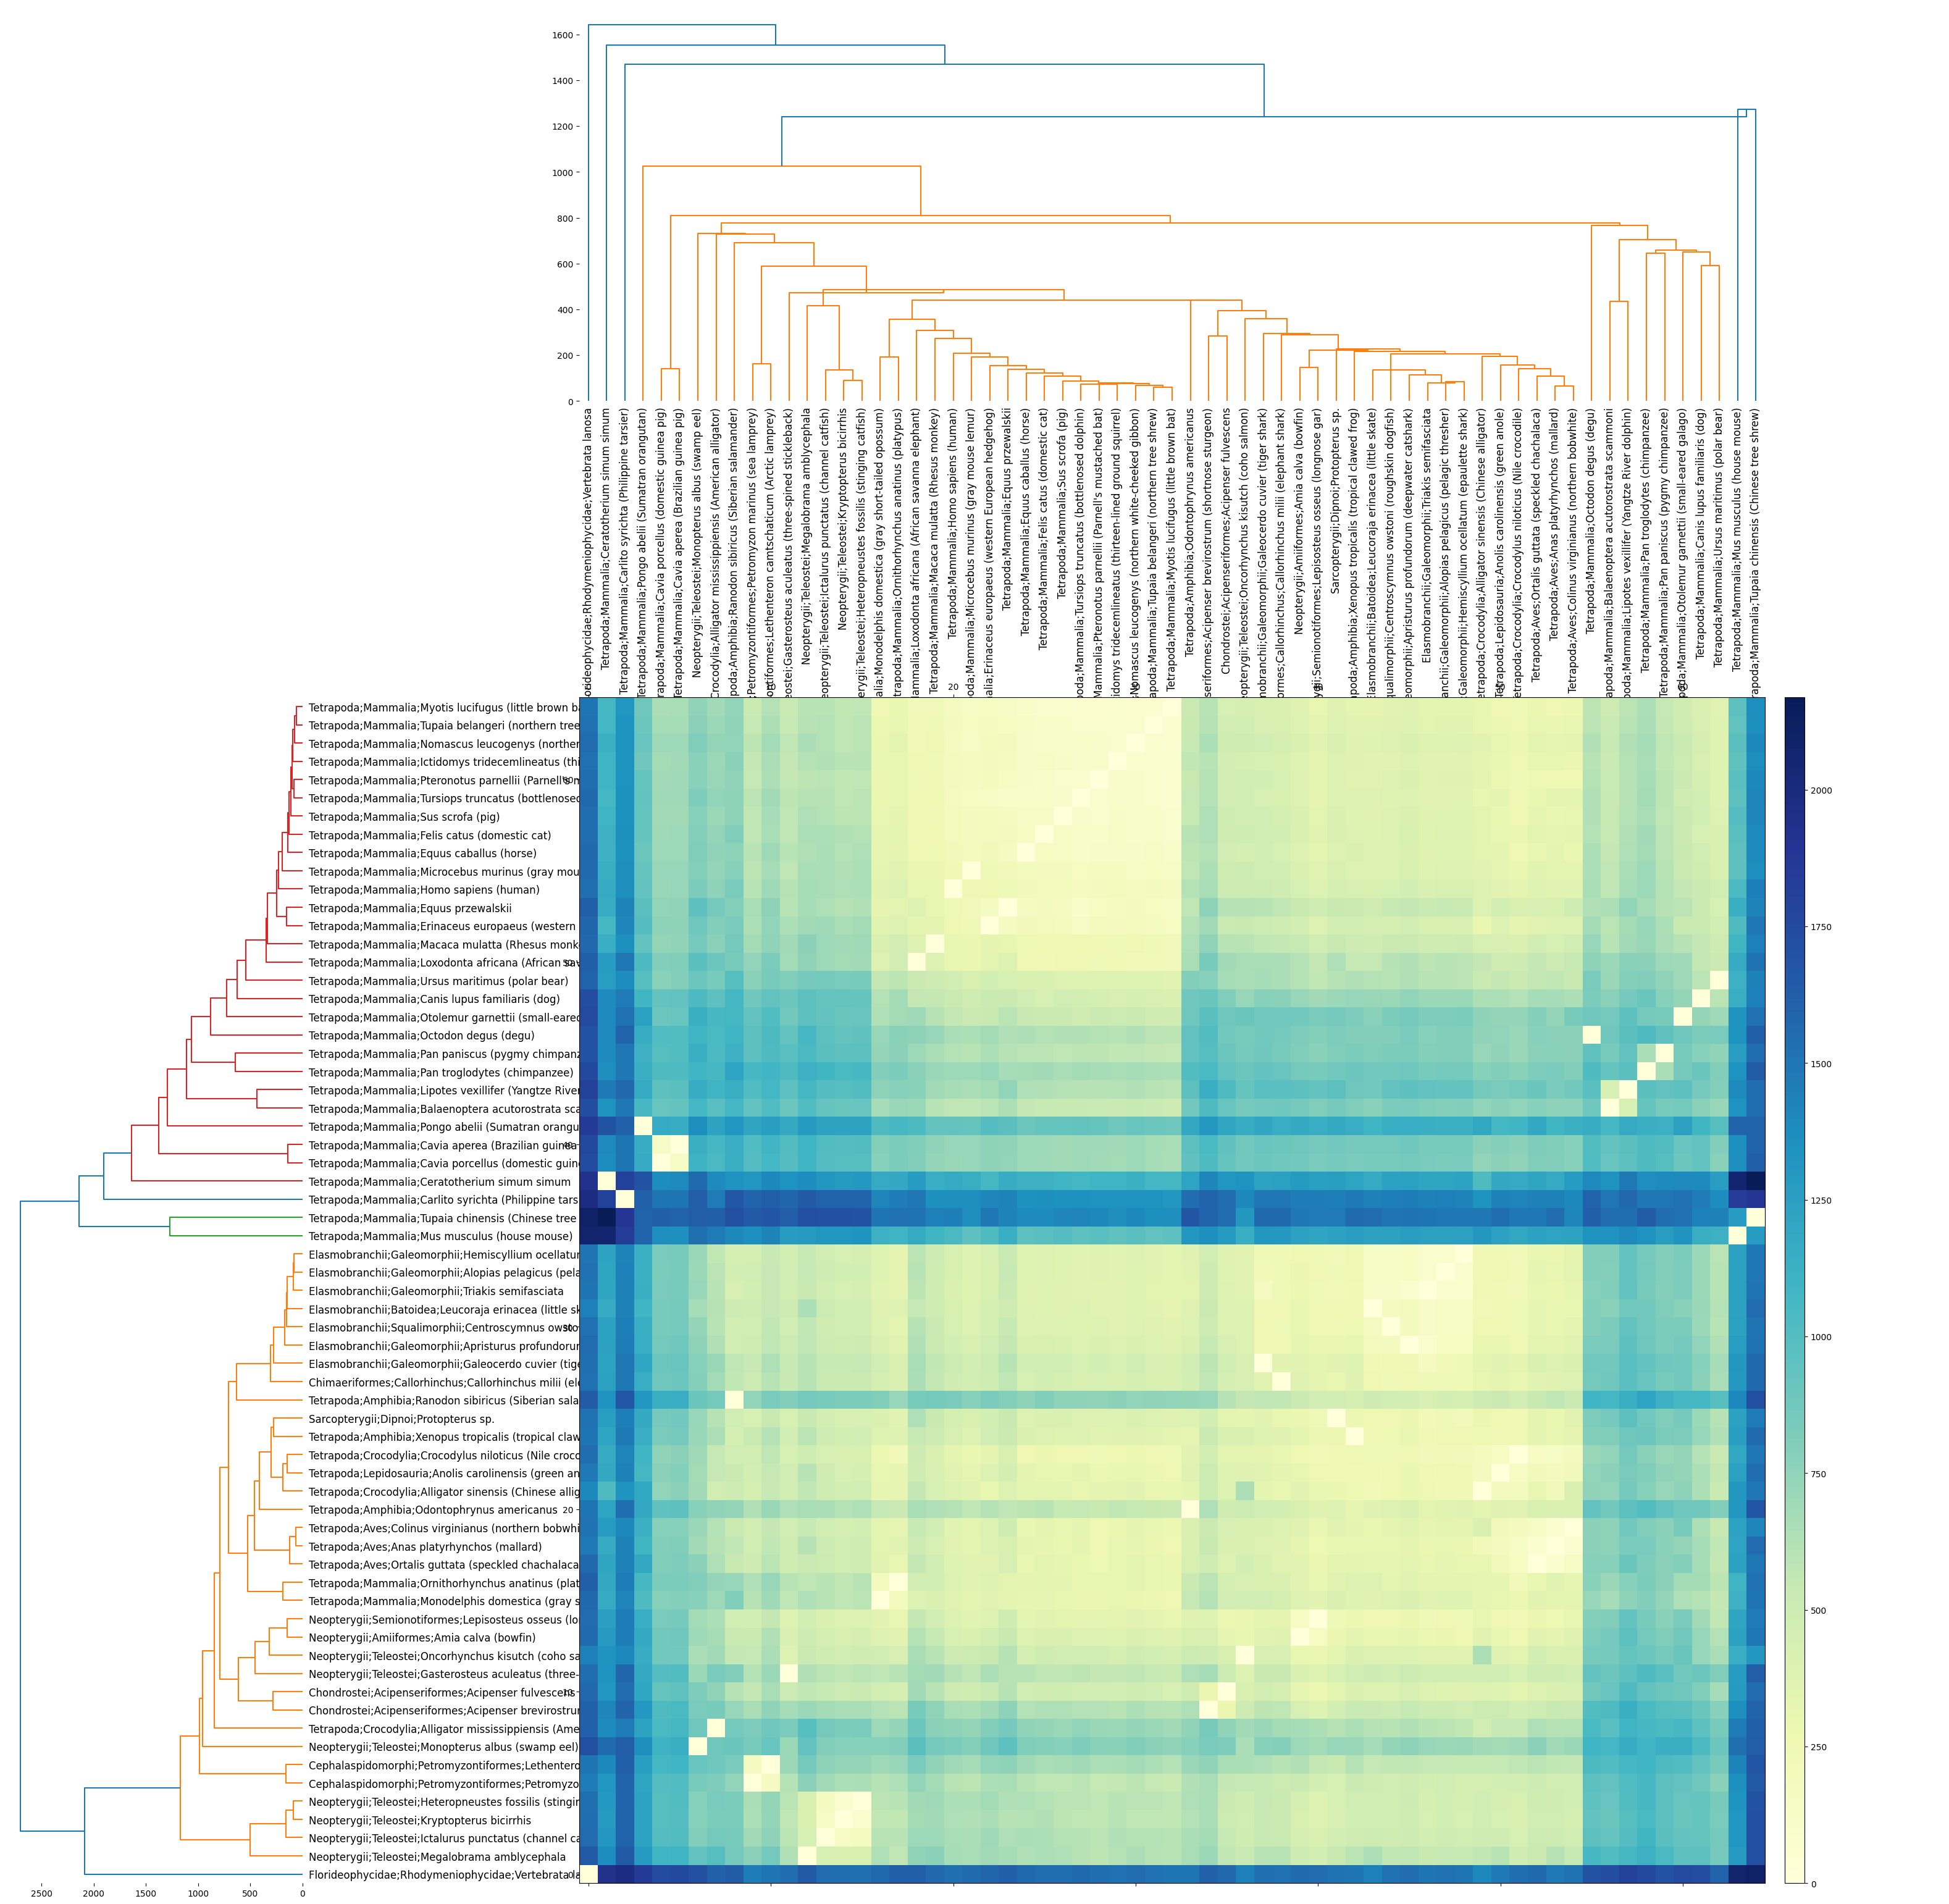

In [ ]:
create_dendogram(matrix, longnames, 'ward', 'median')

Distance matrix shape (65, 65)


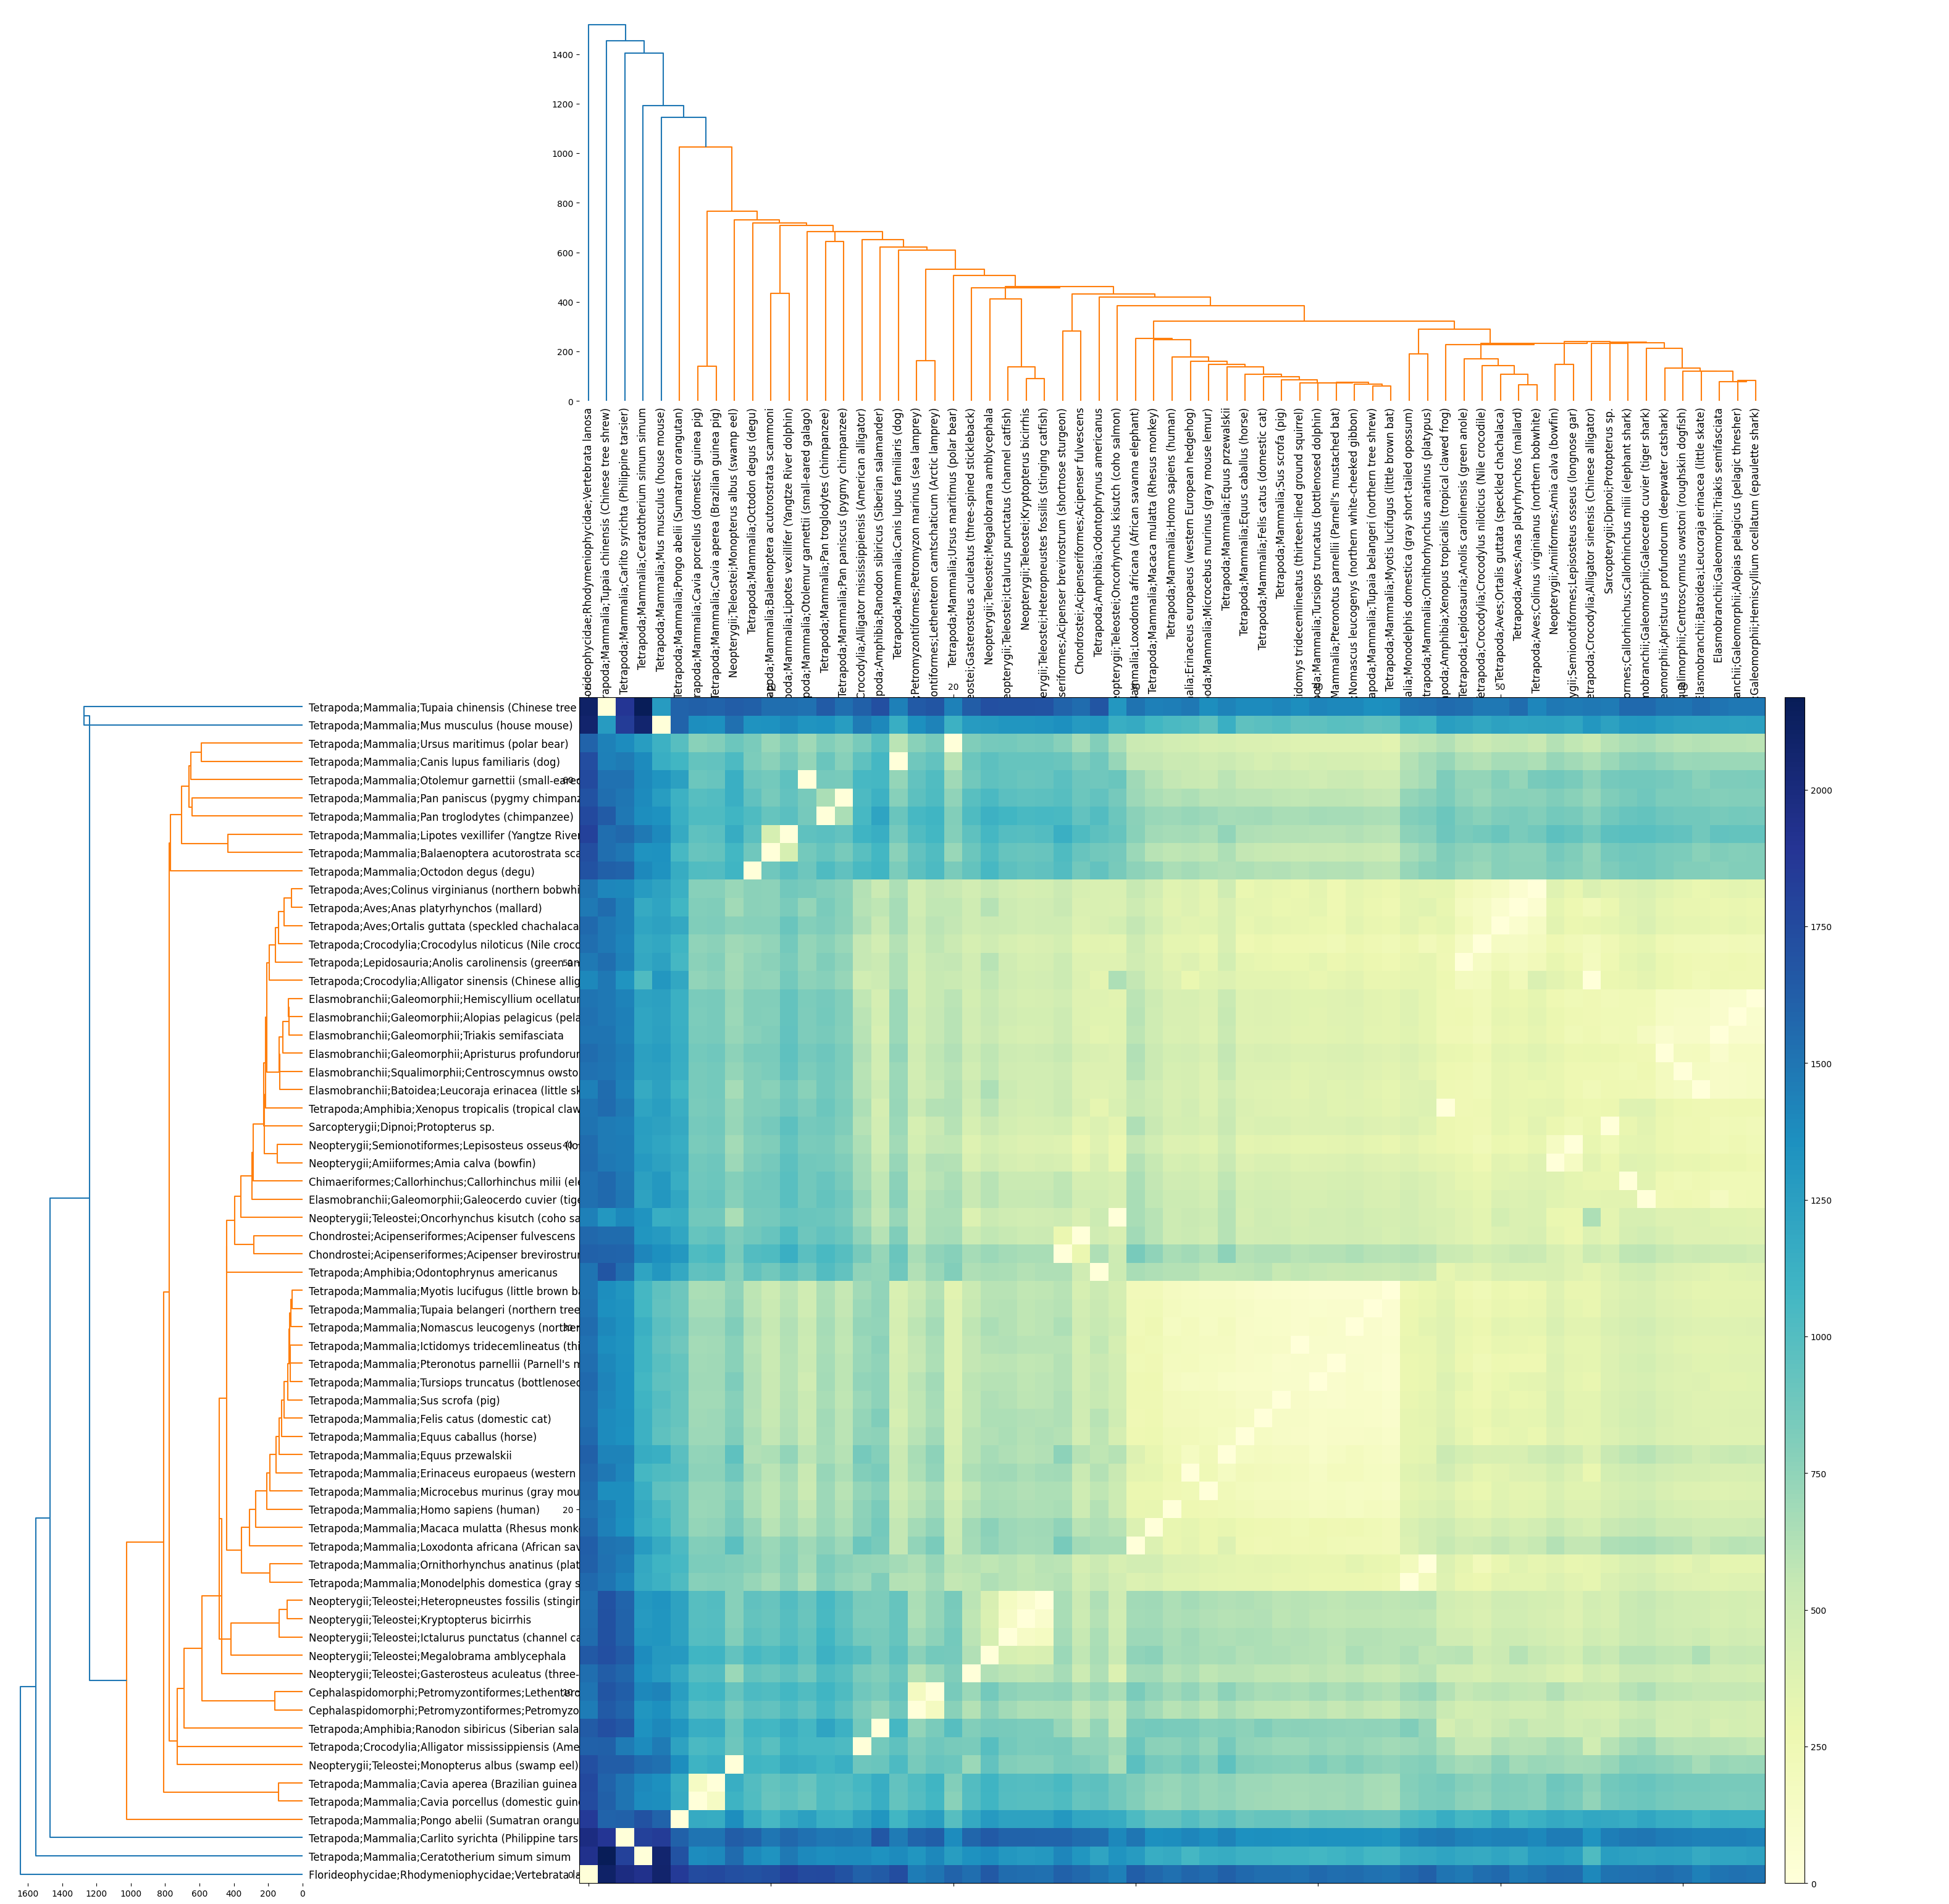

In [ ]:
create_dendogram(matrix, longnames, 'median', 'centroid')

## Sequence Lengths (15 Points) ✅

Not all 18S sequences are of equal length
Some show significant (20%) variation in size

*   Is global alignment a good choice for these? ✅(using semi-global alignment)
*   Investigate if the differences in length can be related to substring matches ✅
*   Filter your dataset to ensure that differences in 18s rRNA sequence length doesn’t have too much of an effect on distance calculations ✅

In [ ]:
#implemented in above codes

## Dataset Size (20 Points) ✅

*   Explore a different branch of the tree of life, and compare your results with the taxonomies present in the database ✅

In [ ]:
keywords = ['Vertebrata']

speciesNameToSequence = get_fasta_sequences_from_zip(zipped_sequence_filename)
print (f"{len(speciesNameToSequence)} names match keywords")

filtered_seqs = trunc_unique_species(60, 1600)

In [ ]:
matrix, shortnames = calculate_dist_matrix(filtered_seqs)

100%|██████████| 1770/1770.0 [00:18<00:00, 95.29it/s] 

Alignments in 18.5809831009974 seconds


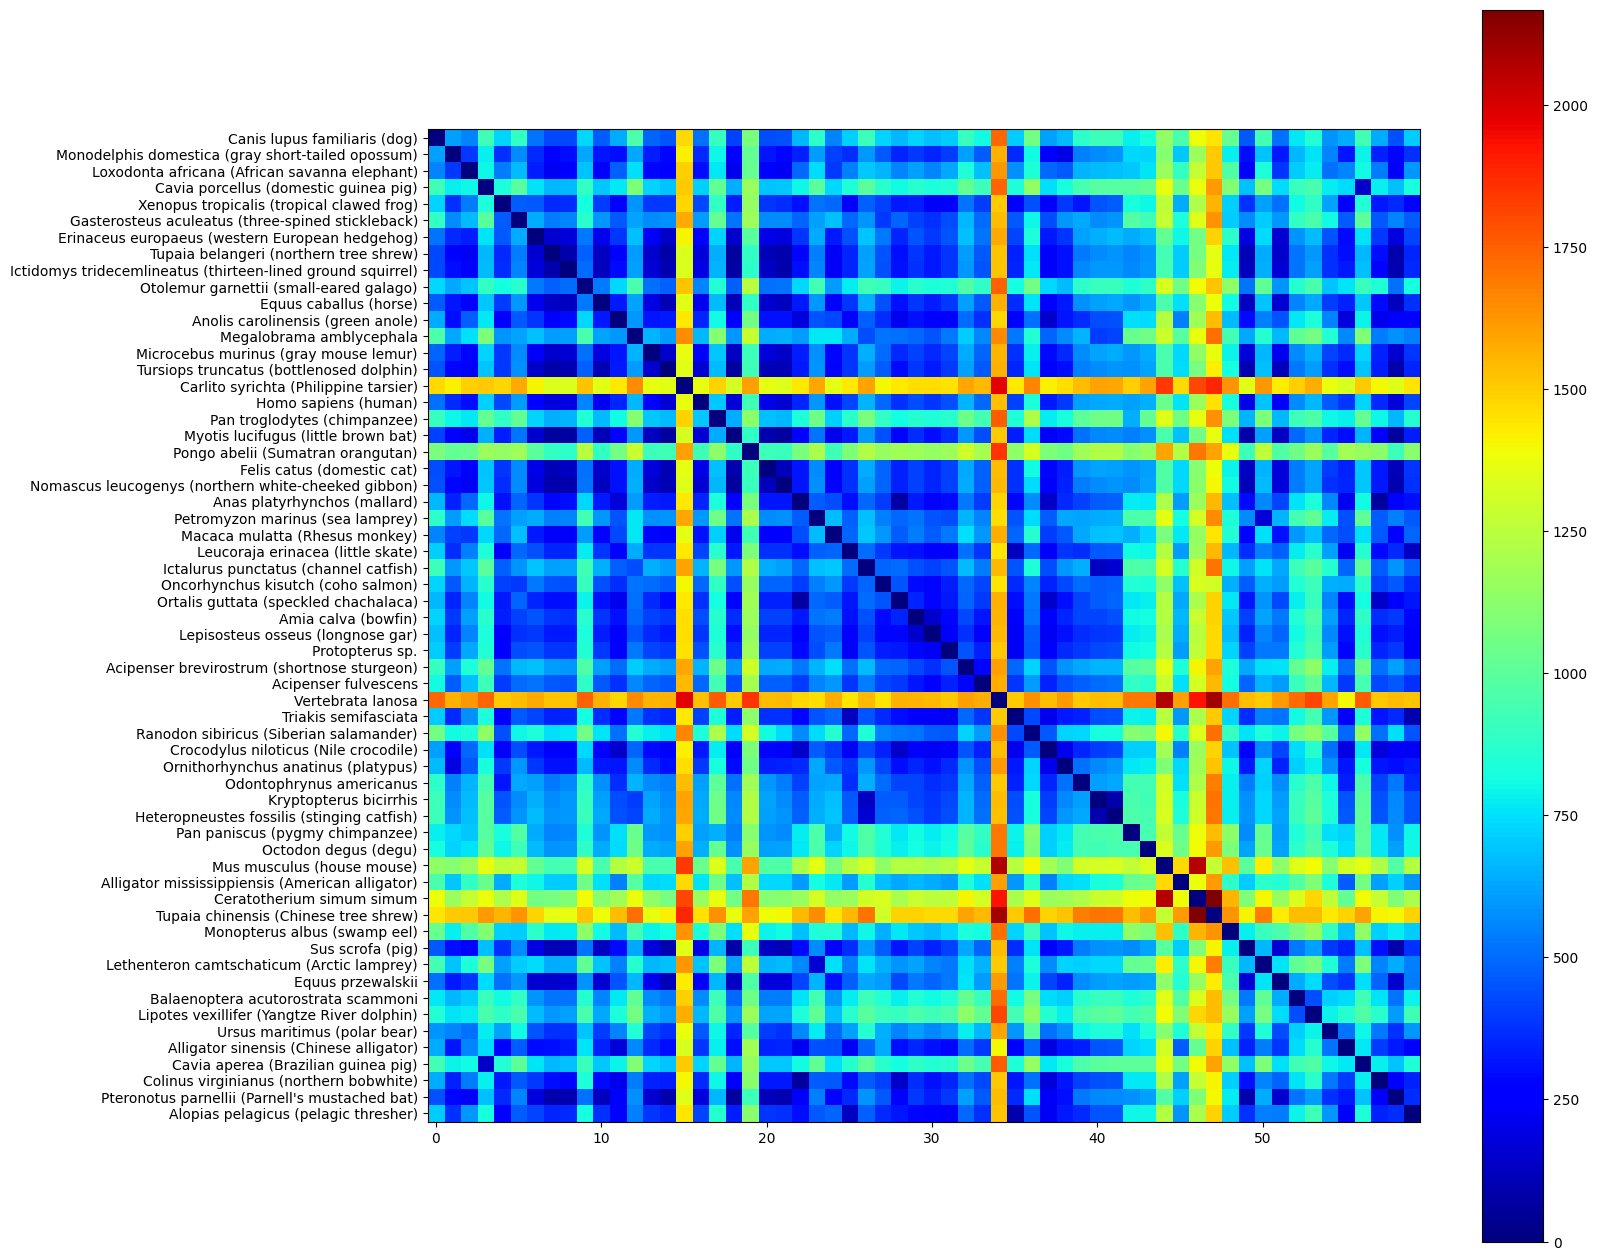

Distance matrix shape (60, 60)


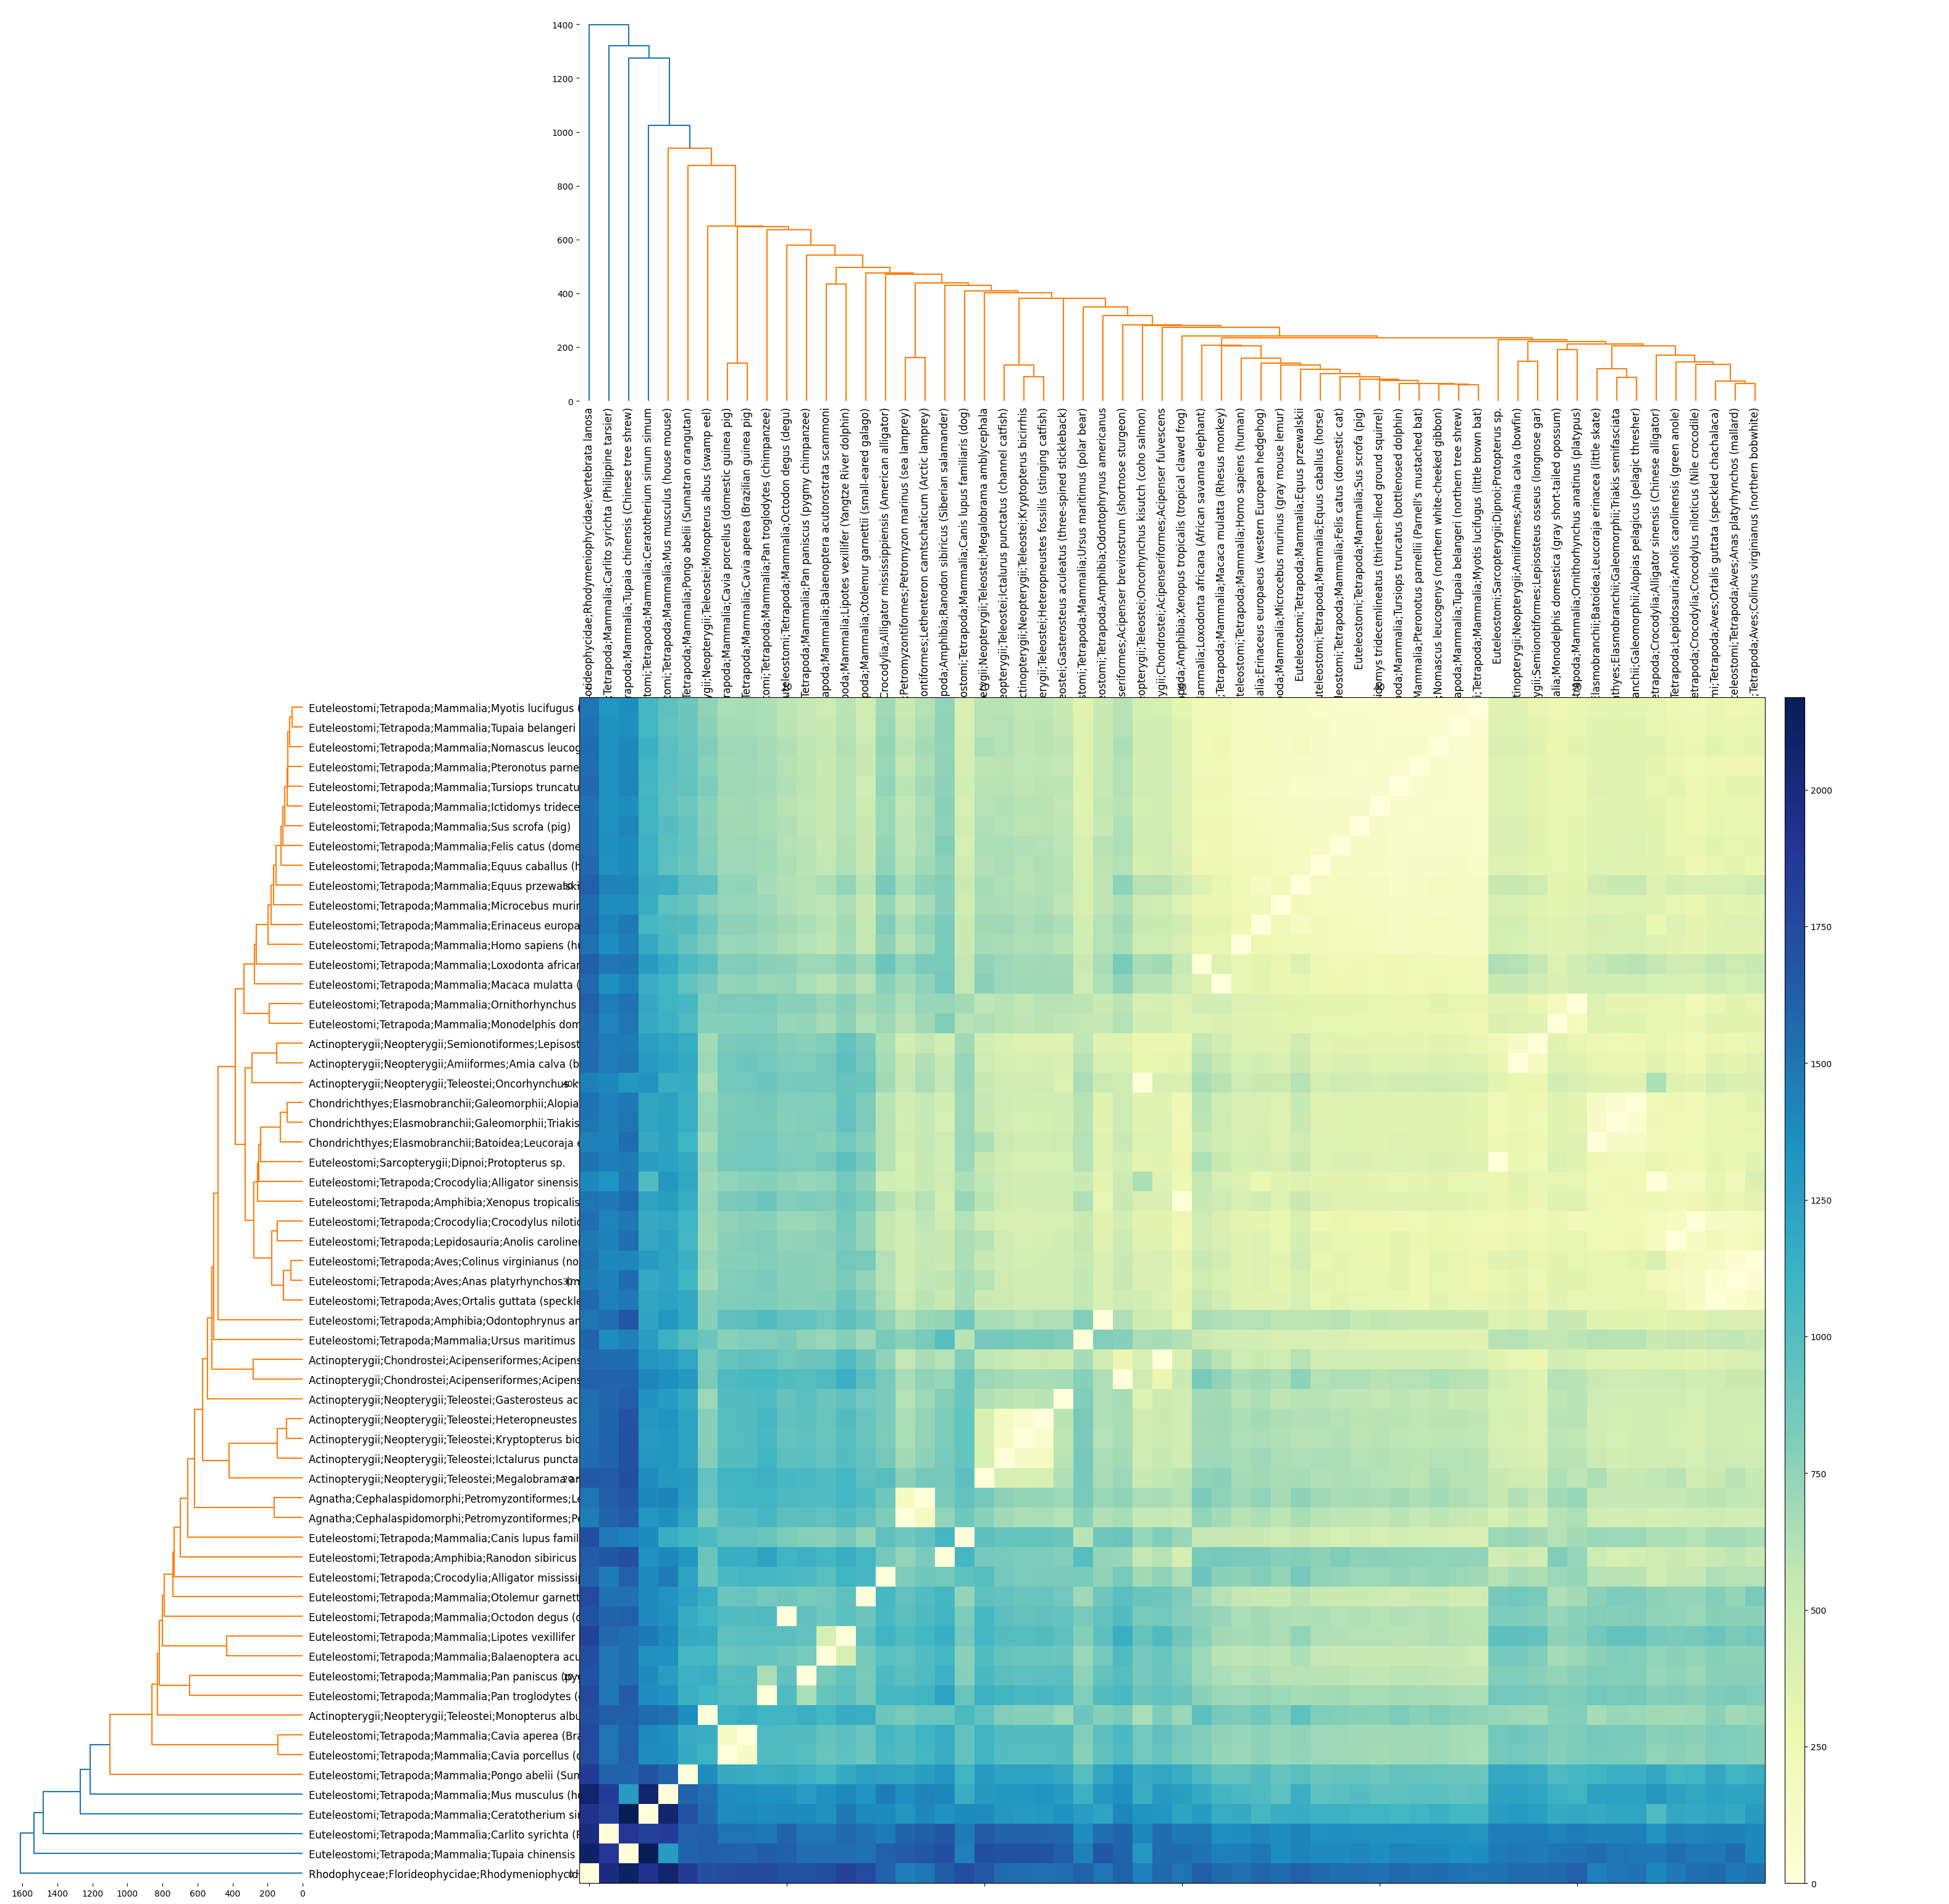

In [ ]:
draw_dist_matrix(matrix, shortnames)
longnames = [';'.join(n.split(';')[-4:]) for n in filtered_seqs.keys()]
create_dendogram(matrix, longnames)

## Gap Open/Extension (15 Points)
A single large insertion/deletion is evolutionarily more likely than multiple small indels grouped together

*   Some aligners don't handle separate gap open/gap extension penalties
*   But distances can still take into account gap open/gap extend

### Task:
*   Calculate the indel size distribution over a set of alignments
*   Do the sizes follow an expected distribution?
*   Capture the distribution in a gap open/gap extension penalty score pair (linear intercept model)


## Best 18S Per-species (25 Points) ✅

Our cells still require a lot of the 18S SSU protein

Many species have multiple copies of the 18S gene, as 18S does not get transcribed into proteins, the RNA itself is the protein, and is thus missing an amplification step.

But 18S sequences may have duplicated both before or after a species divergence event.

### Task:
*   When calculating between-species distance use the distance between the two closest 18S sequences from each species, if any of the species have multiple known 18S sequences. ✅
*   This will greatly increase computational costs for species multiple 18S sequences. ✅ (5 min for ~30 species, depends what subset)


In [ ]:
def get_species_name(name):
  return name.rpartition(';')[2]

def get_species_seqs(species, min_length):
  seqs = {}

  for n in speciesNameToSequence.keys():
    if get_species_name(n) == species and len(speciesNameToSequence[n]) > min_length:
      seqs[n] = speciesNameToSequence[n]

  return seqs

def calculate_dist_matrix_best(species):
  l = len(species)

  distance_matrix = np.zeros((l,l))

  alignment_score_matrix = '\n'.join([
    '    A  C  G  U  *',
    'A   2 -1 -1 -1 -2',
    'C  -1  2 -1 -1 -2',
    'G  -1 -1  2 -1 -2',
    'U  -1 -1 -1  2 -1',
    '*  -2 -2 -2 -2 -2',
  ])

  max_score_per_base = 2

  with open("matrix.txt", 'w') as f: f.write(alignment_score_matrix)

  scoringm = ps.Matrix("matrix.txt")

  big_seqs = {}

  for s in species:
    big_seqs[s] = get_species_seqs(s, 1600)

  total = 0

  for x, s1 in enumerate(species):
    for y, s2 in enumerate(species):
      if y > x:
        total += len(big_seqs[s1].items()) * len(big_seqs[s2].items())

  t0 = time.perf_counter()

  with tqdm(total=total) as pbar:
    for x, name1 in enumerate(species):
      for y, name2 in enumerate(species):
        if x == y:
          distance_matrix[x,y] = 0
        if y > x:
          best_score = float('inf')

          for seqA in big_seqs[name1].values():
            for seqB in big_seqs[name2].values():
              pbar.update(1)
              result = ps.sg_stats_striped_32(seqA, seqB, gap_open, gap_extend, scoringm) #ps.pam250)
              temp_score = max_score_per_base*min(len(seqA),len(seqB)) - result.score #(10000 - result.score) / 11
              if temp_score < best_score:
                best_score = temp_score

          distance_matrix[x,y]= best_score

        else:
          distance_matrix[x,y] = distance_matrix[y,x]


  print (f'Alignments in {time.perf_counter()-t0} seconds')

  shortnames = species

  return distance_matrix, shortnames

In [ ]:
keywords = ['Vertebrata'] #can choose any taxonomy group

speciesNameToSequence = get_fasta_sequences_from_zip(zipped_sequence_filename)
print (f"{len(speciesNameToSequence)} names match keywords")

filtered_seqs = trunc_unique_species(30, 1600)

1106 names match keywords
Number of unique species: 257
Number of sequences: 30
Canis lupus familiaris (dog), Monodelphis domestica (gray short-tailed opossum), Loxodonta africana (African savanna elephant), Cavia porcellus (domestic guinea pig), Xenopus tropicalis (tropical clawed frog), Gasterosteus aculeatus (three-spined stickleback), Erinaceus europaeus (western European hedgehog), Tupaia belangeri (northern tree shrew), Ictidomys tridecemlineatus (thirteen-lined ground squirrel), Otolemur garnettii (small-eared galago), Equus caballus (horse), Anolis carolinensis (green anole), Megalobrama amblycephala, Microcebus murinus (gray mouse lemur), Tursiops truncatus (bottlenosed dolphin), Carlito syrichta (Philippine tarsier), Homo sapiens (human), Pan troglodytes (chimpanzee), Myotis lucifugus (little brown bat), Pongo abelii (Sumatran orangutan), Felis catus (domestic cat), Nomascus leucogenys (northern white-cheeked gibbon), Anas platyrhynchos (mallard), Petromyzon marinus (sea lamp

In [ ]:
species = [get_species_name(n) for n in filtered_seqs.keys()]

matrix, shortnames = calculate_dist_matrix_best(species)

100%|██████████| 26512/26512 [04:58<00:00, 88.95it/s] 

Alignments in 298.0494977160015 seconds


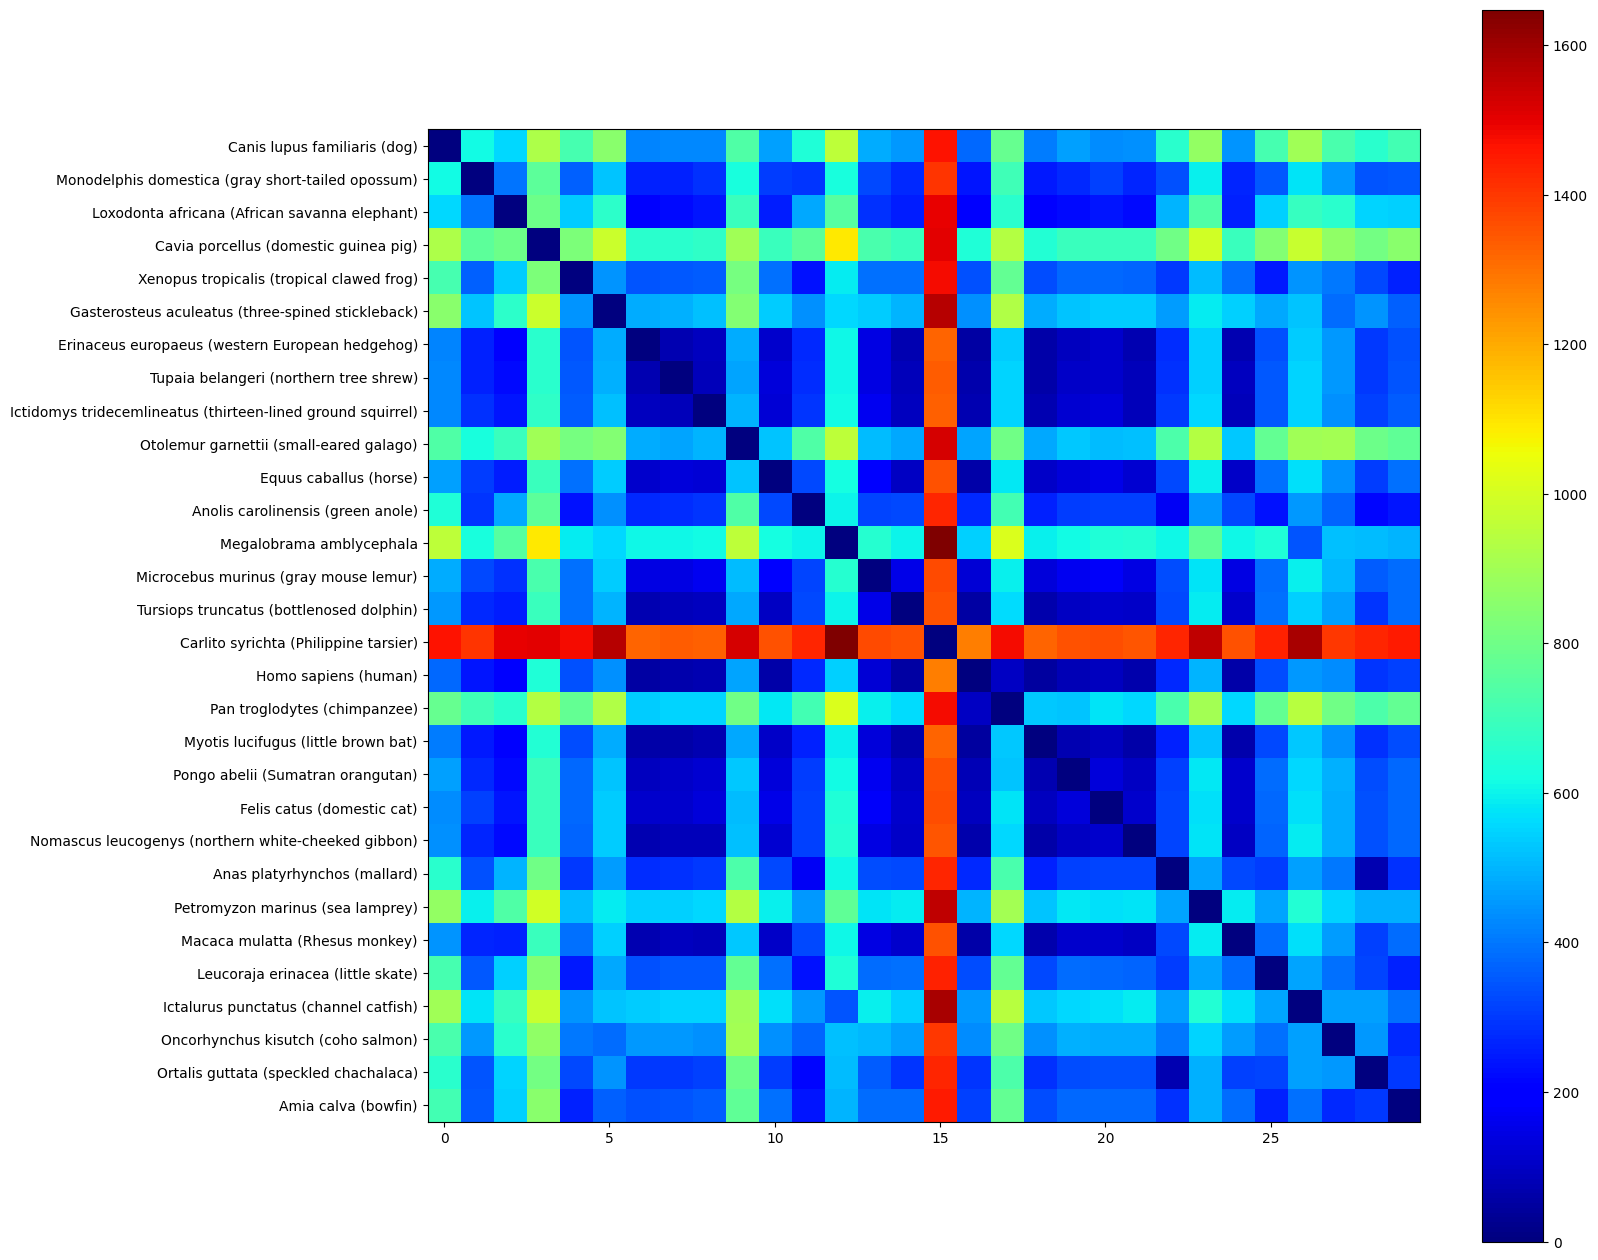

Distance matrix shape (30, 30)


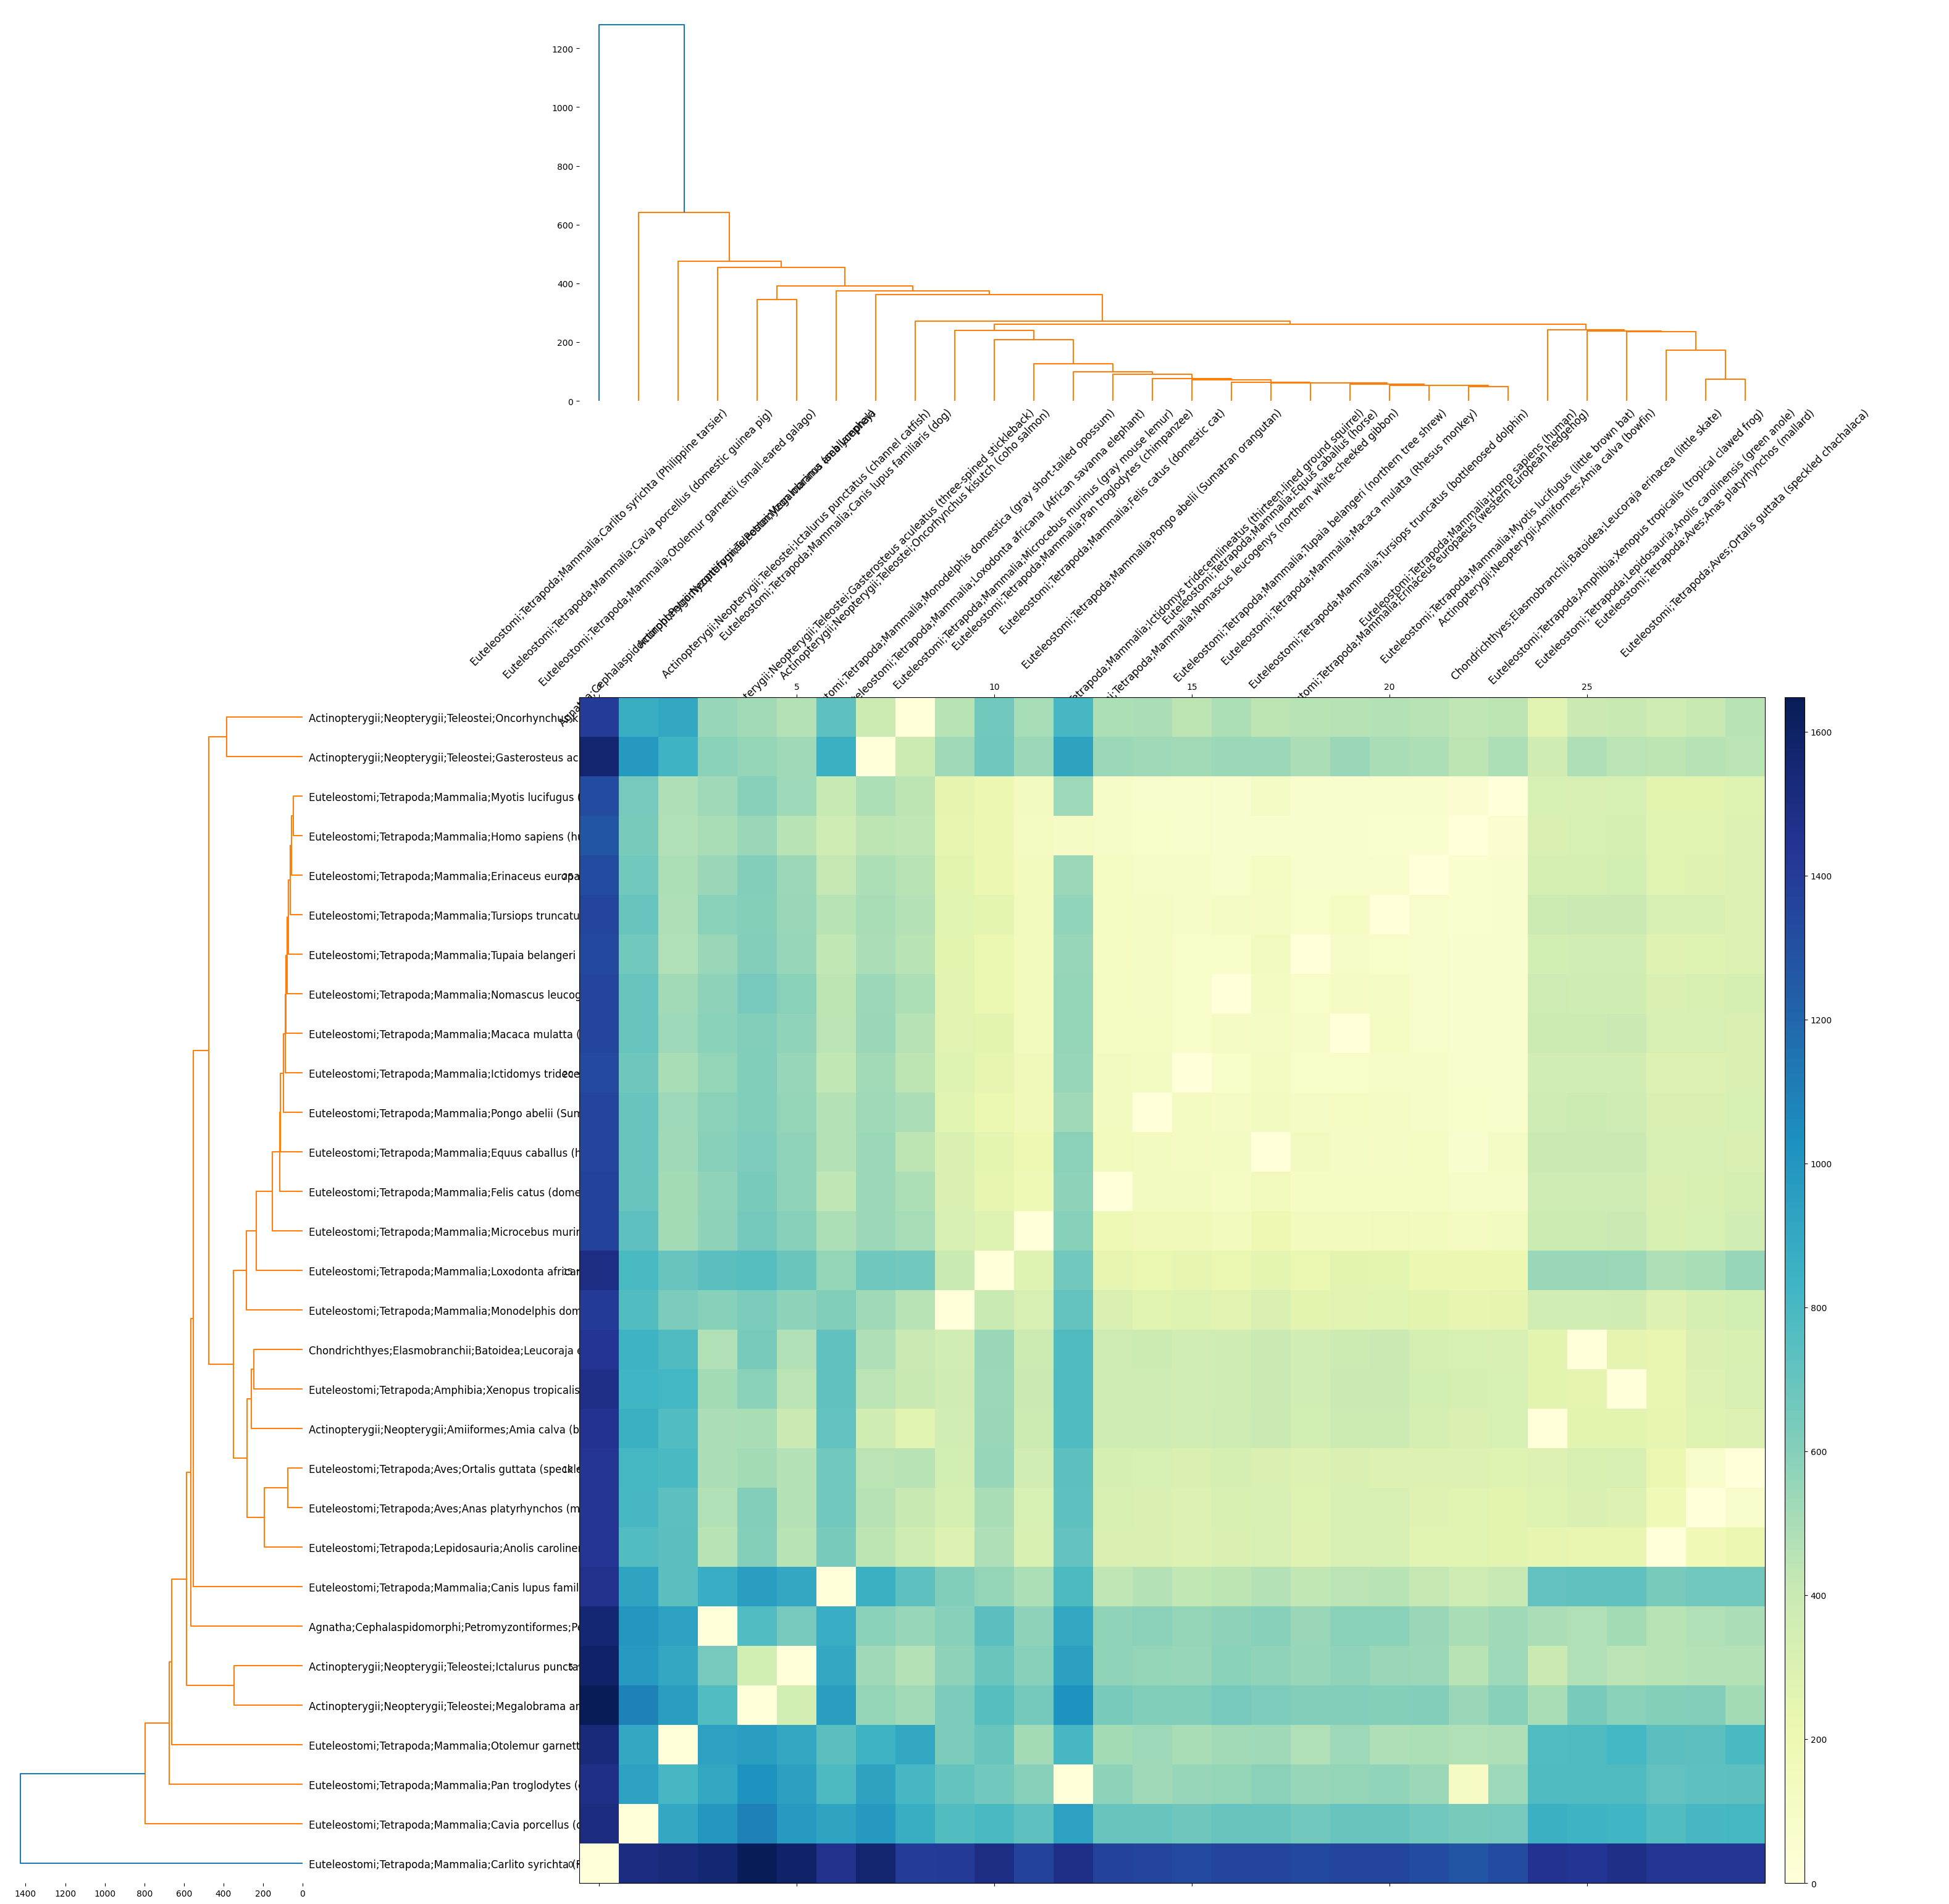

In [ ]:
draw_dist_matrix(matrix, shortnames)
longnames = [';'.join(n.split(';')[-4:]) for n in filtered_seqs.keys()]
create_dendogram(matrix, longnames)

## Any other task (Points to be awarded individually)

If you have any other ideas on what you would like to work on within the scope of the tree of life, please do so below here.

In [ ]:
#Tried to reformat the code to work in functions